<a href="https://colab.research.google.com/github/Sarah-0405/Coldspots_Bayern_Analyse/blob/main/06-LCZs_Coldspots_kombinieren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Vorgehen:**

Local Climate Zone Daten verarbeiten und mit Cold Spot Daten kombinieren => in welchen LCZs kommen Cold Spots vor, Unterschiede in den Städten,...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Local Climate Zone Raster laden

Daten wurden manuell heruntergeladen von https://figshare.com/articles/dataset/European_LCZ_map/13322450 / WUDAPT und dann auf bayern zugeschnitten (QGIS)

LCZs_bayern.tif ist im GitHub Repo verfügbar

In [ ]:
lcz_path = "/content/drive/MyDrive/Cold Spots Bayern/LCZs_bayern.tif"

# Städte extrahieren


In [ ]:
import geopandas as gpd

# Define the path to the GeoPackage file
city_boundaries_path = "/content/drive/MyDrive/Cold Spots Bayern/grenzen_ueber_50tsd.gpkg"

# Load the GeoPackage file into a GeoDataFrame
city_boundaries_gdf = gpd.read_file(city_boundaries_path)

# Display the first few rows and the CRS of the GeoDataFrame
print("City Boundaries GeoDataFrame:")
display(city_boundaries_gdf.head())
print("\nCity Boundaries CRS:")
print(city_boundaries_gdf.crs)

City Boundaries GeoDataFrame:


bbox_west  bbox_south  bbox_east  bbox_north   place_id  osm_type  osm_id  \
0  11.360777   48.061624  11.722910   48.248116  116687199  relation   62428   
1  10.988733   49.331434  11.282596   49.540753  115962439  relation   62780   
2  10.763362   48.258144  10.959333   48.458654  116219980  relation   62407   
3  12.029075   48.966746  12.191608   49.076416  119951011  relation   62411   
4  11.255908   48.683877  11.503422   48.822891  116627625  relation   62381   

         lat        lon     class            type  place_rank  importance  \
0  48.137108  11.575382  boundary  administrative          12    0.799006   
1  49.453872  11.077298  boundary  administrative          12    0.709195   
2  48.369034  10.897952  boundary  administrative          12    0.679385   
3  49.019533  12.097487  boundary  administrative          12    0.670191   
4  48.763016  11.425040  boundary  administrative          12    0.625744   

  addresstype        name                  display_name  \
0        city      Munich      Munich, Bavaria, Germany   
1        city   Nuremberg   Nuremberg, Bavaria, Germany   
2        city    Augsburg    Augsburg, Bavaria, Germany   
3        city  Regensburg  Regensburg, Bavaria, Germany   
4        city  Ingolstadt  Ingolstadt, Bavaria, Germany   

                                            geometry  
0  MULTIPOLYGON (((11.36078 48.15807, 11.36085 48...  
1  MULTIPOLYGON (((10.98873 49.53654, 10.98906 49...  
2  MULTIPOLYGON (((10.76336 48.30213, 10.76336 48...  
3  MULTIPOLYGON (((12.02907 49.01102, 12.02908 49...  
4  MULTIPOLYGON (((11.25591 48.77946, 11.25634 48...


City Boundaries CRS:
EPSG:4326


In [ ]:
import geopandas as gpd
from shapely.geometry import MultiPolygon # Import MultiPolygon if needed

# Step 1: Use the loaded city_boundaries_gdf
# Extract city names and geometries from the GeoDataFrame and retain CRS
cities_to_extract_gdf = {}
# Get the CRS from the original GeoDataFrame
source_crs = city_boundaries_gdf.crs

for index, row in city_boundaries_gdf.iterrows():
    city_name = row['name']
    geometry = row['geometry']

    # Create a GeoSeries for the individual geometry with the source CRS
    # This ensures the geometry object is associated with the CRS
    if source_crs is not None:
        geo_series = gpd.GeoSeries([geometry], crs=source_crs)
        geometry_with_crs = geo_series.iloc[0]
    else:
        geometry_with_crs = geometry # Use geometry without CRS if source_crs is None


    cities_to_extract_gdf[city_name] = geometry_with_crs


# Step 2 & 3: Store the information (already done in the dictionary)
print("Cities to extract and their geometries from city_boundaries_gdf:")
for city, geometry in cities_to_extract_gdf.items():
    # Create a GeoSeries to associate CRS with the geometry for printing
    if geometry.geom_type in ['Polygon', 'MultiPolygon']: # Check for polygon types
        geo_series_for_print = gpd.GeoSeries([geometry], crs=source_crs) # Associate CRS
        print(f"- {city}: {geometry.geom_type}, CRS: {geo_series_for_print.crs}")
    else:
        # Handle other geometry types or cases where CRS might not be applicable in the same way
        print(f"- {city}: {geometry.geom_type}, CRS: Not applicable/defined for this geometry type in this context")

Cities to extract and their geometries from city_boundaries_gdf:
- Munich: MultiPolygon, CRS: EPSG:4326
- Nuremberg: MultiPolygon, CRS: EPSG:4326
- Augsburg: MultiPolygon, CRS: EPSG:4326
- Regensburg: MultiPolygon, CRS: EPSG:4326
- Ingolstadt: MultiPolygon, CRS: EPSG:4326
- Würzburg: MultiPolygon, CRS: EPSG:4326
- Fürth: MultiPolygon, CRS: EPSG:4326
- Erlangen: MultiPolygon, CRS: EPSG:4326
- Bamberg: MultiPolygon, CRS: EPSG:4326
- Bayreuth: MultiPolygon, CRS: EPSG:4326
- Aschaffenburg: MultiPolygon, CRS: EPSG:4326
- Landshut: MultiPolygon, CRS: EPSG:4326
- Kempten (Allgäu): MultiPolygon, CRS: EPSG:4326
- Rosenheim: MultiPolygon, CRS: EPSG:4326
- Schweinfurt: MultiPolygon, CRS: EPSG:4326
- Passau: MultiPolygon, CRS: EPSG:4326


## Raster zuschneiden (Clipping)

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 85.3 MB/s eta 0:00:00


In [ ]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from rasterio.warp import transform
import numpy as np # Import numpy for np.all

# Open the raster file
with rasterio.open(lcz_path) as src:
    # Get the raster's coordinate reference system (CRS)
    raster_crs = src.crs

    clipped_rasters = {}

    # Define the input CRS of the city boundary geometries (from city_boundaries_gdf)
    input_crs = city_boundaries_gdf.crs # Use the CRS directly from the source GeoDataFrame

    if input_crs is None:
        print("Warning: Input city boundaries GeoDataFrame does not have a defined CRS.")
        # You might need to set a default input_crs here if it's expected to be known
        # For now, we'll proceed, but transformation might fail if CRS is needed.

    for city, geometry in cities_to_extract_gdf.items():
        try:
            # Create a GeoSeries for the current geometry with the input CRS
            # This is the correct way to associate a CRS with a shapely geometry for transformation
            if input_crs is not None:
                geo_series = gpd.GeoSeries([geometry], crs=input_crs)
            else:
                # If input_crs is None, create GeoSeries without CRS - transformation below will likely fail if needed
                geo_series = gpd.GeoSeries([geometry])


            # Ensure the city geometry is in the raster's CRS for accurate clipping
            # Transform the GeoSeries to the raster's CRS
            if geo_series.crs != raster_crs:
                 print(f"Transforming geometry for {city} from {geo_series.crs} to {raster_crs}")
                 transformed_geometry = geo_series.to_crs(raster_crs).iloc[0]
            else:
                # If the geometry's CRS already matches the raster's CRS (unlikely given the source)
                transformed_geometry = geo_series.iloc[0]
                print(f"Geometry for {city} already in raster CRS ({raster_crs}).")


            # Use the transformed geometry directly for masking
            # mask expects a list of geometries
            geoms = [transformed_geometry]

            # Clip the raster using the transformed city boundary geometry
            # Setting crop=True will crop the output raster to the extent of the clipping geometry
            clipped_data, clipped_transform = mask(src, geoms, crop=True)

            # Store the clipped data and its transform if the clipped data is not empty
            # Check if clipped_data is not None and has data
            if clipped_data is not None and clipped_data.size > 0 and not np.all(clipped_data == src.nodata): # Also check if not all nodata
                 clipped_rasters[city] = {
                    "data": clipped_data,
                    "transform": clipped_transform,
                    "crs": src.crs,
                    "meta": src.meta.copy() # Copy metadata
                }
                # Update metadata for the clipped raster
                 clipped_rasters[city]["meta"].update({
                    "height": clipped_data.shape[1],
                    "width": clipped_data.shape[2],
                    "transform": clipped_transform
                })
                 print(f"Successfully clipped raster for {city}.")
            else:
                print(f"Clipped data for {city} is empty or all NoData. Geometry might be outside raster extent or cover only NoData areas.")
                clipped_rasters[city] = None # Indicate clipping resulted in empty or nodata data


        except Exception as e:
            print(f"Could not clip raster for {city} due to an error: {e}")
            clipped_rasters[city] = None # Indicate clipping failed for this city


# Now clipped_rasters dictionary contains the clipped data for each city (or None if failed)
print("\nClipped rasters created (or attempted) for the specified cities.")

# Filter out cities where clipping failed
successfully_clipped_cities = {city: data for city, data in clipped_rasters.items() if data is not None}

if not successfully_clipped_cities:
    print("\nNo rasters were successfully clipped.")
else:
    print(f"\nSuccessfully clipped rasters for the following cities: {list(successfully_clipped_cities.keys())}")

Transforming geometry for Munich from EPSG:4326 to EPSG:3035
Successfully clipped raster for Munich.
Transforming geometry for Nuremberg from EPSG:4326 to EPSG:3035
Successfully clipped raster for Nuremberg.
Transforming geometry for Augsburg from EPSG:4326 to EPSG:3035
Successfully clipped raster for Augsburg.
Transforming geometry for Regensburg from EPSG:4326 to EPSG:3035
Successfully clipped raster for Regensburg.
Transforming geometry for Ingolstadt from EPSG:4326 to EPSG:3035
Successfully clipped raster for Ingolstadt.
Transforming geometry for Würzburg from EPSG:4326 to EPSG:3035
Successfully clipped raster for Würzburg.
Transforming geometry for Fürth from EPSG:4326 to EPSG:3035
Successfully clipped raster for Fürth.
Transforming geometry for Erlangen from EPSG:4326 to EPSG:3035
Successfully clipped raster for Erlangen.
Transforming geometry for Bamberg from EPSG:4326 to EPSG:3035
Successfully clipped raster for Bamberg.
Transforming geometry for Bayreuth from EPSG:4326 to EPSG

## Visualisierung

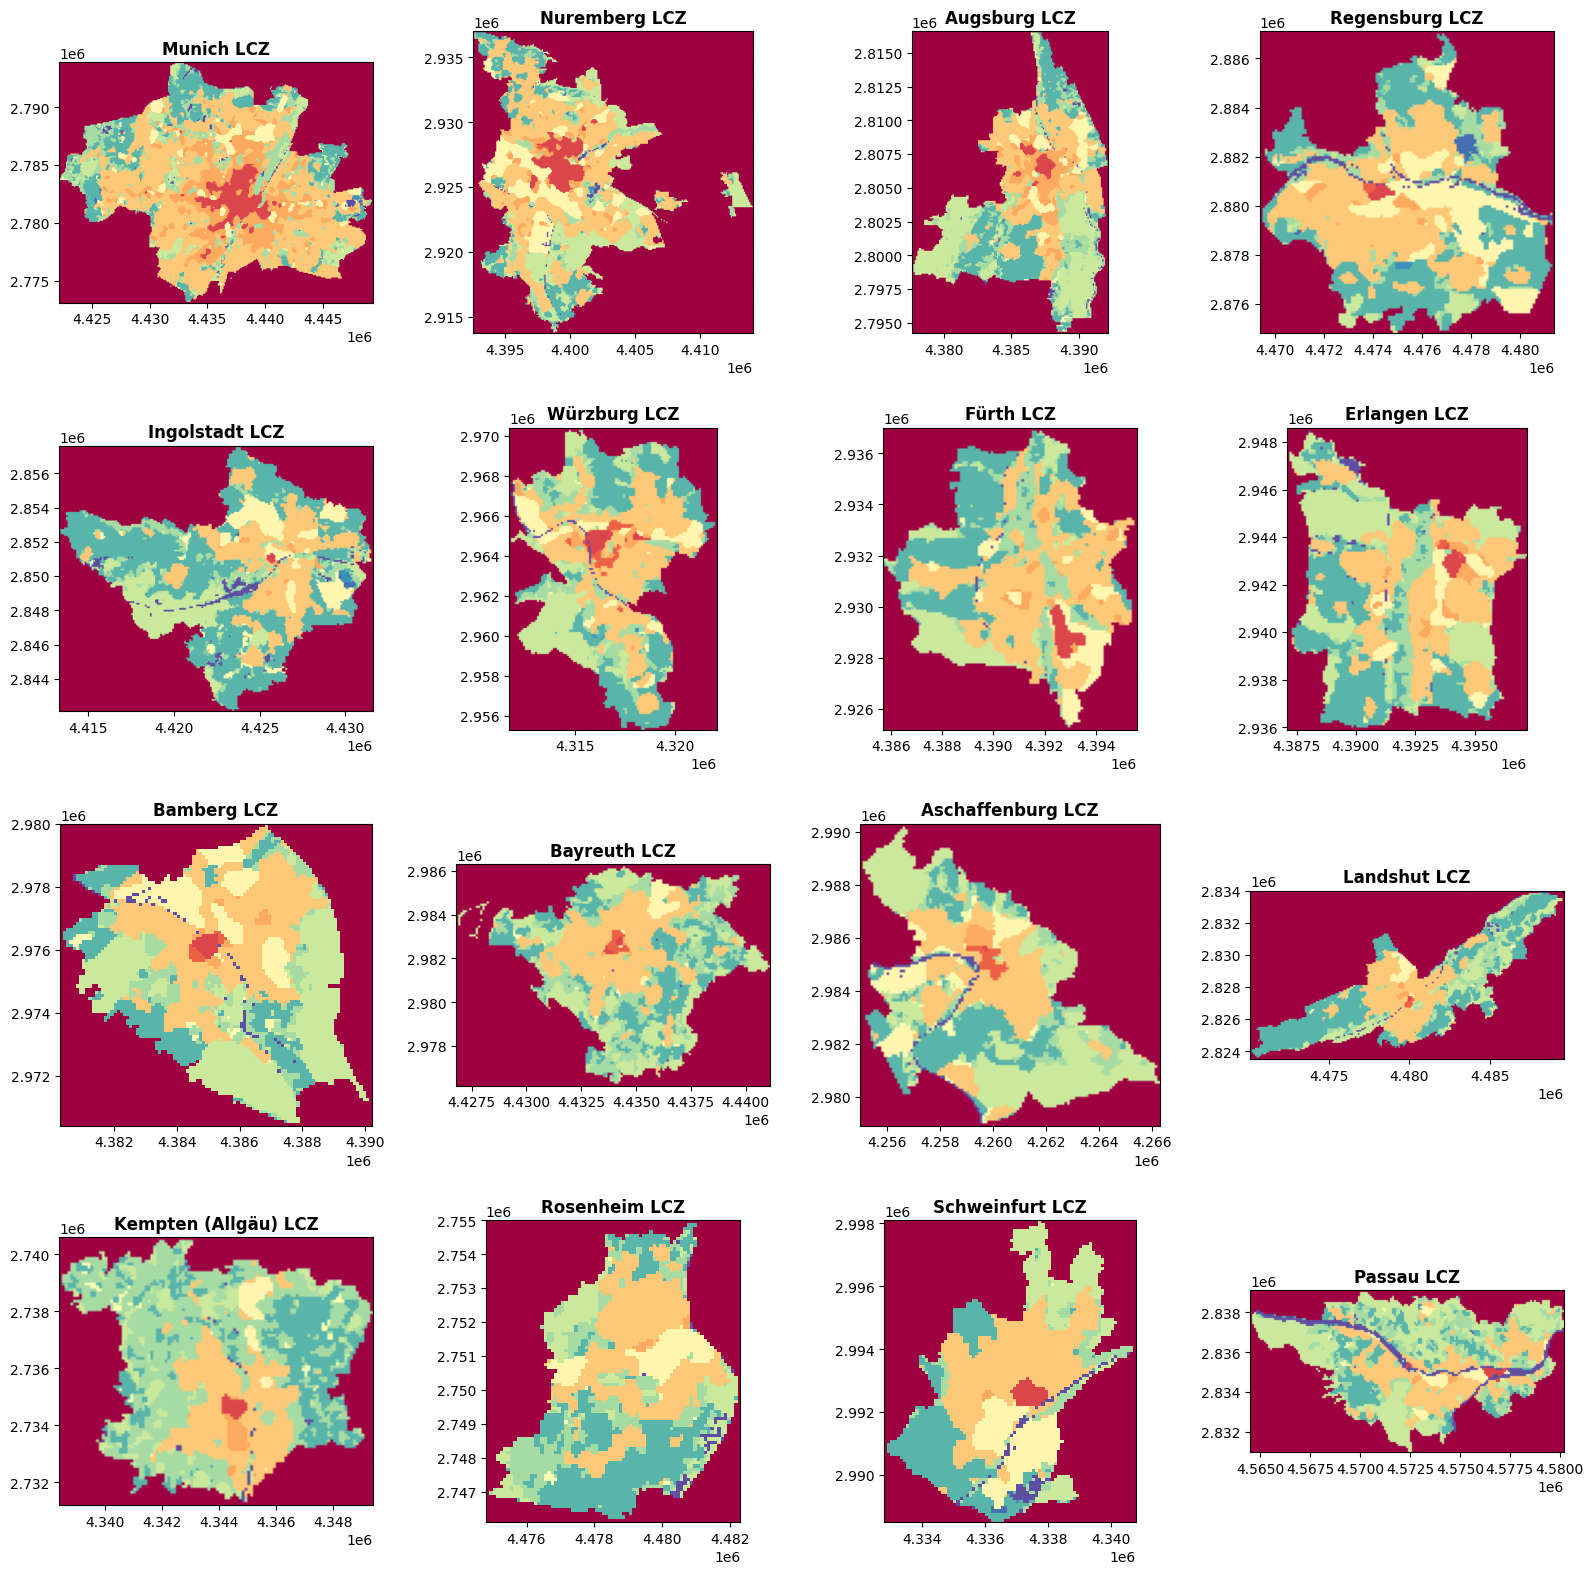

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

# Filter out cities where clipping was not successful
cities_to_visualize = {city: data for city, data in clipped_rasters.items() if data is not None}

if not cities_to_visualize:
    print("No cities were successfully clipped, so no visualizations can be displayed.")
else:
    # Determine the number of cities and calculate grid dimensions for subplots
    num_cities = len(cities_to_visualize)
    cols = 4  # Number of columns for the grid
    rows = (num_cities + cols - 1) // cols # Calculate rows needed

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate through the successfully clipped rasters and plot each one
    for i, (city, clipped_info) in enumerate(cities_to_visualize.items()):
        clipped_data = clipped_info["data"]
        clipped_transform = clipped_info["transform"]
        clipped_crs = clipped_info["crs"]

        # Assuming the clipped data is a single band (shape: (1, height, width))
        # Extract the single band for plotting
        if clipped_data.shape[0] == 1:
             clipped_band = clipped_data[0]
        else:
             # Handle multi-band rasters if necessary, for LCZ it's usually single band
             clipped_band = clipped_data[0] # Take the first band as default


        # Use rasterio's show function to plot on the current subplot
        show(clipped_band, ax=axes[i], transform=clipped_transform, cmap='Spectral', title=f'{city} LCZ')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# mit Cold Spot Daten verknüpfen

Cold Spot Daten laden und überprüfen, in welchen LCZs die Cold Spots liegen

In [ ]:
import geopandas as gpd
import os
import pandas as pd # Import pandas for numeric conversion

# Define the base directory in Google Drive where the Cold Spot results are saved
input_base_dir = "/content/drive/MyDrive/Cold Spots Bayern/"

# Define the input folder for the filtered results
# Corrected folder name based on previous user request
input_folder_filtered = os.path.join(input_base_dir, "Gi_Ergebnisse_2019_2024_Puffer_gefiltert")

# Initialize a dictionary to store the loaded and filtered Cold Spot geodataframes
loaded_and_filtered_cold_spots = {}

print(f"Lade gefilterte Cold Spots (p<0.01) für 2019-2024 aus dem Ordner: {input_folder_filtered}")

# Load Cold Spots from the filtered folder and apply the significance level filter
if os.path.exists(input_folder_filtered):
    for filename in os.listdir(input_folder_filtered):
        # Process both .gpkg and .geojson files
        if filename.endswith((".gpkg")):
            file_path = os.path.join(input_folder_filtered, filename)
            try:
                gdf = gpd.read_file(file_path)

                # Convert 'gi_star_p_sim' to numeric, coercing errors to NaN
                # This handles cases where some values might not be numbers
                if 'gi_star_p_sim' in gdf.columns:
                    gdf['gi_star_p_sim'] = pd.to_numeric(gdf['gi_star_p_sim'], errors='coerce')

                    # Filter the GeoDataFrame to include only cold spots with gi_star_p_sim < 0.01
                    # Also drop rows where gi_star_p_sim is NaN after coercion
                    filtered_gdf = gdf[gdf['gi_star_p_sim'].notna() & (gdf['gi_star_p_sim'] < 0.01)].copy() # Use .copy()

                    if not filtered_gdf.empty:
                        # Extract city name from filename
                        city_name = filename.replace(".geojson", "").replace(".gpkg", "").replace("_", " ")
                        # Attempt to clean up the city name to match expected keys
                        city_name = city_name.replace("Ergebnisse gefiltert", "").strip()
                        city_name = city_name.replace("cold spots 2019-2024 p010", "").strip()
                        city_name = city_name.replace("cold spots 2019-2024 p005", "").strip()
                        city_name = city_name.replace("Gi_", "").strip()

                        # Handle specific city name variations/umlauts
                        city_name = city_name.replace("ae", "ä").replace("oe", "ö").replace("ue", "ü").replace("Ue", "Ü")
                        city_name = city_name.replace("Kempten Allgaeu", "Kempten (Allgäu)") # Specific handling

                        loaded_and_filtered_cold_spots[city_name] = filtered_gdf
                        print(f"  Geladen und gefiltert: {filename} ({city_name}, {len(filtered_gdf)} cold spots with p<0.01)")
                    else:
                        print(f"  Geladen: {filename} - Keine Cold Spots mit p<0.01 gefunden oder alle Werte in gi_star_p_sim waren ungültig.")
                else:
                    print(f"  Fehler: 'gi_star_p_sim' Spalte nicht gefunden in {filename}.")


            except Exception as e:
                print(f"  Fehler beim Laden oder Filtern von {filename}: {e}")
else:
    print(f"  Ordner nicht gefunden: {input_folder_filtered}")


print("\nLaden und Filtern der Cold Spot Ergebnisse für 2019-2024 abgeschlossen.")

# The dictionary 'loaded_and_filtered_cold_spots' now contains the geodataframes
# with cold spots where gi_star_p_sim < 0.01 for each city.

# You can now access the loaded and filtered cold spot geodataframes using the dictionary
# For example: munich_cold_spots_filtered = loaded_and_filtered_cold_spots['Munich']

Lade gefilterte Cold Spots (p<0.01) für 2019-2024 aus dem Ordner: /content/drive/MyDrive/Cold Spots Bayern/Gi_Ergebnisse_2019_2024_Puffer_gefiltert
  Geladen und gefiltert: Aschaffenburg_2019_2024_cold_spots_combined_2019_2024.gpkg (Aschaffenburg 2019 2024 cold spots combined 2019 2024, 21478 cold spots with p<0.01)
  Geladen und gefiltert: Augsburg_2019_2024_cold_spots_combined_2019_2024.gpkg (Augsburg 2019 2024 cold spots combined 2019 2024, 39974 cold spots with p<0.01)
  Geladen und gefiltert: Bamberg_2019_2024_cold_spots_combined_2019_2024.gpkg (Bamberg 2019 2024 cold spots combined 2019 2024, 39625 cold spots with p<0.01)
  Geladen und gefiltert: Bayreuth_2019_2024_cold_spots_combined_2019_2024.gpkg (Bayreuth 2019 2024 cold spots combined 2019 2024, 46299 cold spots with p<0.01)
  Geladen und gefiltert: Erlangen_2019_2024_cold_spots_combined_2019_2024.gpkg (Erlangen 2019 2024 cold spots combined 2019 2024, 29333 cold spots with p<0.01)
  Geladen und gefiltert: Fürth_2019_2024_co

## Crs-Check und -Anpassung

In [ ]:
loaded_and_filtered_cold_spots_transformed = {}

# Create a mapping from the potentially messy cold spot keys to the cleaned city names
# that match the clipped_rasters keys.
# This mapping needs to be built based on the actual keys in loaded_and_filtered_cold_spots
# and how they relate to the keys in clipped_rasters.

# Let's generate a mapping by trying to clean the keys from loaded_and_filtered_cold_spots
# and see if they match any keys in clipped_rasters.
key_mapping = {}
for cold_spot_key in loaded_and_filtered_cold_spots.keys():
    # Apply cleaning logic to get a base city name
    cleaned_city_name = cold_spot_key.replace("_2019_2024_cold_spots_combined_2019_2024", "").strip()
    cleaned_city_name = cleaned_city_name.replace("Ergebnisse gefiltert", "").strip()
    cleaned_city_name = cleaned_city_name.replace("cold spots 2019-2024 p010", "").strip()
    cleaned_city_name = cleaned_city_name.replace("cold spots 2019-2024 p005", "").strip()
    cleaned_city_name = cleaned_city_name.replace("Gi_", "").strip()
    cleaned_city_name = cleaned_city_name.replace("_", " ").strip() # Replace remaining underscores with spaces

    # Normalize umlauts and handle specific cases
    cleaned_city_name = cleaned_city_name.replace("ä", "ae").replace("ö", "oe").replace("ü", "ue").replace("Ä", "Ae").replace("Ö", "Oe").replace("Ü", "Ue")
    # Specific handling for Kempten (Allgäu) - ensure consistent representation
    cleaned_city_name = cleaned_city_name.replace("Kempten Allgaeu", "Kempten (Allgäu)").replace("Kempten (Allgäu)", "Kempten (Allgäu)")
    # Handle specific utf-8 representations if necessary for other cities
    cleaned_city_name = cleaned_city_name.replace("Fürth", "Fürth")
    cleaned_city_name = cleaned_city_name.replace("Würzburg", "Würzburg")


    # Now, try to find a match in clipped_rasters keys.
    # Prioritize exact case-insensitive match. If that fails, try partial match, but with caution.
    matched_clipped_key = None
    for clipped_key in clipped_rasters.keys():
        if clipped_rasters[clipped_key] is not None:
            # Try exact match (case-insensitive) first
            if cleaned_city_name.lower() == clipped_key.lower():
                matched_clipped_key = clipped_key
                break # Found an exact match, stop searching

    # If no exact match was found, try partial matching (be cautious with this)
    if matched_clipped_key is None:
         for clipped_key in clipped_rasters.keys():
            if clipped_rasters[clipped_key] is not None:
                # Check if the cleaned cold spot name is a substring of the clipped key or vice versa
                if cleaned_city_name.lower() in clipped_key.lower() or clipped_key.lower() in cleaned_city_name.lower():
                    matched_clipped_key = clipped_key
                    print(f"Partial match found: Cold spot key '{cold_spot_key}' (cleaned: '{cleaned_city_name}') matched with clipped key '{clipped_key}'")
                    break # Found a partial match, stop searching


    if matched_clipped_key:
        key_mapping[cold_spot_key] = matched_clipped_key
    else:
         print(f"Warning: Could not find a reliable matching clipped raster for cold spot data key: '{cold_spot_key}' (Cleaned name: '{cleaned_city_name}'). This city's cold spot data will be skipped for analysis.")


# Now iterate through the cold spot data using the successful mapping
for cold_spot_key, cleaned_city_name in key_mapping.items():
    gdf = loaded_and_filtered_cold_spots[cold_spot_key]
    # Ensure the matched clipped raster actually exists and is not None
    if cleaned_city_name in clipped_rasters and clipped_rasters[cleaned_city_name] is not None:
        raster_crs = clipped_rasters[cleaned_city_name]['crs']

        if gdf.crs != raster_crs:
            print(f"Transforming CRS for {cleaned_city_name} from {gdf.crs} to {raster_crs}")
            loaded_and_filtered_cold_spots_transformed[cleaned_city_name] = gdf.to_crs(raster_crs)
        else:
            print(f"CRS for {cleaned_city_name} already matches.")
            loaded_and_filtered_cold_spots_transformed[cleaned_city_name] = gdf.copy()
    else:
        print(f"Error: Clipped raster for '{cleaned_city_name}' was expected but not found or was None. Skipping CRS transformation for this city.")


print("\nCRS transformation process completed.")

# Display the CRS of the first transformed GeoDataFrame as a check
if loaded_and_filtered_cold_spots_transformed:
    first_city = list(loaded_and_filtered_cold_spots_transformed.keys())[0]
    print(f"\nCRS of transformed data for '{first_city}': {loaded_and_filtered_cold_spots_transformed[first_city].crs}")
else:
    print("\nNo cold spot data was successfully transformed. Check the key mapping and input data.")

Partial match found: Cold spot key 'Aschaffenburg 2019 2024 cold spots combined 2019 2024' (cleaned: 'Aschaffenburg 2019 2024 cold spots combined 2019 2024') matched with clipped key 'Aschaffenburg'
Partial match found: Cold spot key 'Augsburg 2019 2024 cold spots combined 2019 2024' (cleaned: 'Augsburg 2019 2024 cold spots combined 2019 2024') matched with clipped key 'Augsburg'
Partial match found: Cold spot key 'Bamberg 2019 2024 cold spots combined 2019 2024' (cleaned: 'Bamberg 2019 2024 cold spots combined 2019 2024') matched with clipped key 'Bamberg'
Partial match found: Cold spot key 'Bayreuth 2019 2024 cold spots combined 2019 2024' (cleaned: 'Bayreuth 2019 2024 cold spots combined 2019 2024') matched with clipped key 'Bayreuth'
Partial match found: Cold spot key 'Erlangen 2019 2024 cold spots combined 2019 2024' (cleaned: 'Erlangen 2019 2024 cold spots combined 2019 2024') matched with clipped key 'Erlangen'
Partial match found: Cold spot key 'Fürth 2019 2024 cold spots comb

## Extraktion der LCZ-Werte

### Subtask:
Extrahieren Sie für jeden Cold Spot (Punkt) den LCZ-Wert (Pixelwert) aus dem entsprechenden zugeschnittenen LCZ-Raster der Stadt.

In [ ]:
import numpy as np
import rasterio
from shapely.geometry import Point # Import Point if needed

cold_spots_with_lcz = {}

print("Starting LCZ value extraction...")

# Iterate through the successfully transformed cold spot data
for city, gdf in loaded_and_filtered_cold_spots_transformed.items():
    print(f"\nProcessing city: {city}")
    if city in clipped_rasters and clipped_rasters[city] is not None:
        clipped_raster_info = clipped_rasters[city]
        clipped_data = clipped_raster_info["data"]
        clipped_transform = clipped_raster_info["transform"]
        clipped_crs = clipped_raster_info["crs"]
        clipped_meta = clipped_raster_info["meta"]

        # Get raster bounds in its own CRS
        raster_bounds = rasterio.transform.array_bounds(clipped_meta['height'], clipped_meta['width'], clipped_transform)
        print(f"  Clipped Raster Bounds (xmin, ymin, xmax, ymax): {raster_bounds}")
        print(f"  Clipped Raster Shape (bands, height, width): {clipped_data.shape}")
        print(f"  Clipped Raster CRS: {clipped_crs}")


        lcz_values = []
        # Iterate through each cold spot geometry in the GeoDataFrame
        # Limit the number of cold spots to check/print for to avoid excessive output
        sample_size = min(len(gdf), 5) # Check up to 5 cold spots

        for i, (index, row) in enumerate(gdf.iterrows()):
            # Get the centroid of the geometry (handles points, polygons, etc.)
            # Using centroid is a common approach for extracting raster values for polygons
            if row.geometry and not row.geometry.is_empty: # Check if geometry exists and is not empty
                centroid = row.geometry.centroid
                x, y = centroid.x, centroid.y

                if i < sample_size:
                    print(f"    Checking Cold Spot {i+1} (Centroid) at coordinates (x, y): ({x}, {y})")

                # Convert spatial coordinates to pixel indices
                # Use the inverse of the raster's transform
                row_idx, col_idx = rasterio.transform.rowcol(clipped_transform, x, y)

                if i < sample_size:
                    print(f"    Calculated pixel indices (row, col): ({row_idx}, {col_idx})")


                # Check if the indices are within the bounds of the clipped raster data
                if 0 <= row_idx < clipped_data.shape[1] and 0 <= col_idx < clipped_data.shape[2]:
                    # Extract the pixel value (LCZ) at the location
                    # Assuming the clipped data is (band, height, width)
                    lcz_value = clipped_data[0, row_idx, col_idx]
                    lcz_values.append(lcz_value)
                    if i < sample_size:
                         print(f"    Extracted LCZ value: {lcz_value}")
                else:
                    lcz_values.append(None) # Append None if outside bounds
                    if i < sample_size:
                        print(f"    Cold spot centroid is outside the bounds of the clipped raster.")

            else:
                 lcz_values.append(None) # Handle empty or None geometries
                 if i < sample_size:
                     print(f"    Geometry is empty or None for this feature.")


        # Add the extracted LCZ values as a new column to the GeoDataFrame
        gdf['lcz_value'] = lcz_values

        # Store the updated GeoDataFrame
        cold_spots_with_lcz[city] = gdf
        print(f"Extracted LCZ values for cold spots in {city}.")

    else:
        print(f"Clipped raster data not found for {city}, skipping LCZ extraction.")


print("\nLCZ value extraction for cold spots completed.")

# You can now access the GeoDataFrames with LCZ values from the cold_spots_with_lcz dictionary
# For example: munich_cold_spots_with_lcz = cold_spots_with_lcz['Munich']

## Analyse und Zusammenfassung

In [ ]:
# Define a dictionary to store the LCZ descriptions
# Based on the LCZ classification system
lcz_descriptions = {
    1: "Compact High-Rise",
    2: "Compact Midrise",
    3: "Compact Low-Rise",
    4: "Open High-Rise",
    5: "Open Midrise",
    6: "Open Low-Rise",
    7: "Lightweight Low-Rise",
    8: "Large Low-Rise",
    9: "Sparsely Built",
    10: "Heavy Industry",
    11: "Dense Trees",
    12: "Scattered Trees",
    13: "Bush or Scrub",
    14: "Low plants",
    15: "Bare Rock or Paved",
    16: "Bare Soil or Sand",
    17: "Water",
    # Add other potential LCZ values and their descriptions if known
    0: "No Data/Outside LCZ mask" # Assuming 0 might represent no data or areas outside the LCZ mask
}


lcz_cold_spot_counts = {}

print("Summary of Cold Spot distribution across LCZs 2019-2024:")

# Iterate through the cities with extracted LCZ values
for city, gdf in cold_spots_with_lcz.items():
    print(f"\n--- {city} ---")

    # Filter out rows where LCZ value is None (cold spot outside raster extent)
    gdf_valid_lcz = gdf.dropna(subset=['lcz_value'])

    if not gdf_valid_lcz.empty:
        # Count the occurrences of each LCZ value
        lcz_counts = gdf_valid_lcz['lcz_value'].value_counts().sort_index()

        lcz_cold_spot_counts[city] = lcz_counts

        # Display the counts with LCZ descriptions
        for lcz_value, count in lcz_counts.items():
            # Ensure LCZ value is an integer for lookup
            lcz_value_int = int(lcz_value)
            description = lcz_descriptions.get(lcz_value_int, "Unknown LCZ")
            print(f"LCZ {lcz_value_int} ({description}): {count} Cold Spots")

    else:
        print("No Cold Spots found within the LCZ raster extent for this city.")

print("\nAnalysis of Cold Spot distribution across LCZs completed.")

# lcz_cold_spot_counts dictionary contains the counts for each city

Summary of Cold Spot distribution across LCZs 2019-2024:

--- Aschaffenburg ---
LCZ 0 (No Data/Outside LCZ mask): 166 Cold Spots
LCZ 6 (Open Low-Rise): 1530 Cold Spots
LCZ 8 (Large Low-Rise): 190 Cold Spots
LCZ 9 (Sparsely Built): 926 Cold Spots
LCZ 11 (Dense Trees): 8952 Cold Spots
LCZ 12 (Scattered Trees): 4334 Cold Spots
LCZ 14 (Low plants): 3968 Cold Spots
LCZ 15 (Bare Rock or Paved): 24 Cold Spots
LCZ 17 (Water): 1388 Cold Spots

--- Augsburg ---
LCZ 0 (No Data/Outside LCZ mask): 140 Cold Spots
LCZ 2 (Compact Midrise): 2 Cold Spots
LCZ 5 (Open Midrise): 850 Cold Spots
LCZ 6 (Open Low-Rise): 5068 Cold Spots
LCZ 8 (Large Low-Rise): 78 Cold Spots
LCZ 9 (Sparsely Built): 584 Cold Spots
LCZ 11 (Dense Trees): 7878 Cold Spots
LCZ 12 (Scattered Trees): 16292 Cold Spots
LCZ 14 (Low plants): 7704 Cold Spots
LCZ 17 (Water): 1378 Cold Spots

--- Bamberg ---
LCZ 0 (No Data/Outside LCZ mask): 162 Cold Spots
LCZ 5 (Open Midrise): 12 Cold Spots
LCZ 6 (Open Low-Rise): 4956 Cold Spots
LCZ 8 (Large 

## Visualisierung von Cold Spots auf LCZ-Rastern mit Legende

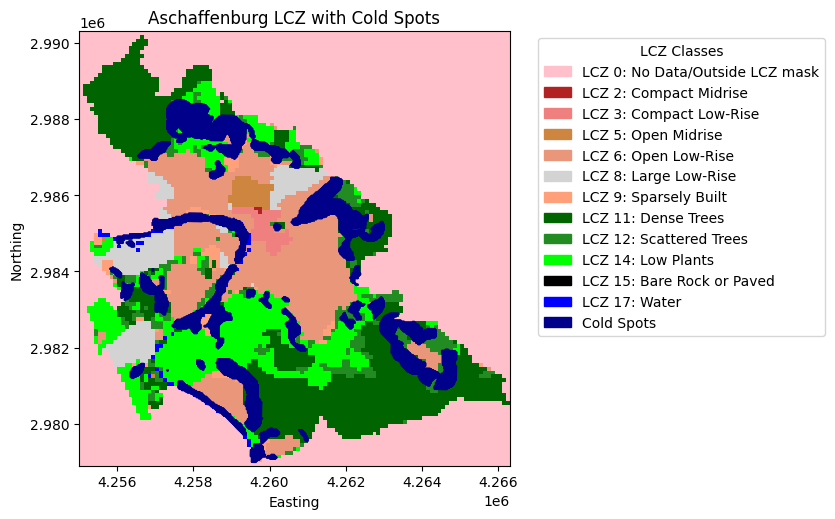

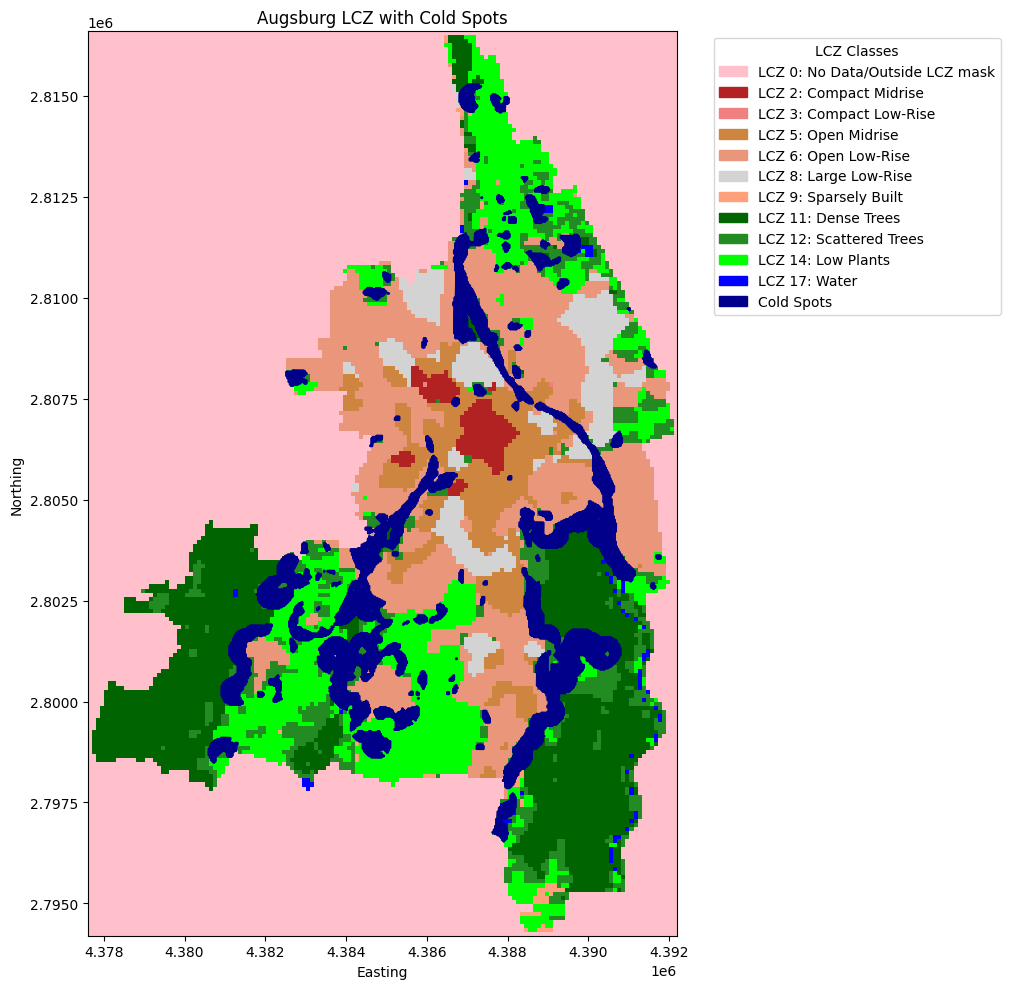

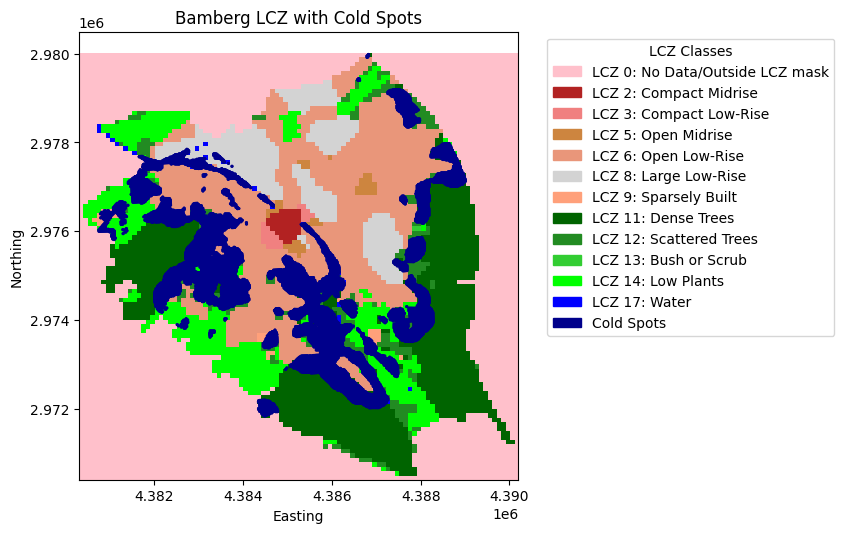

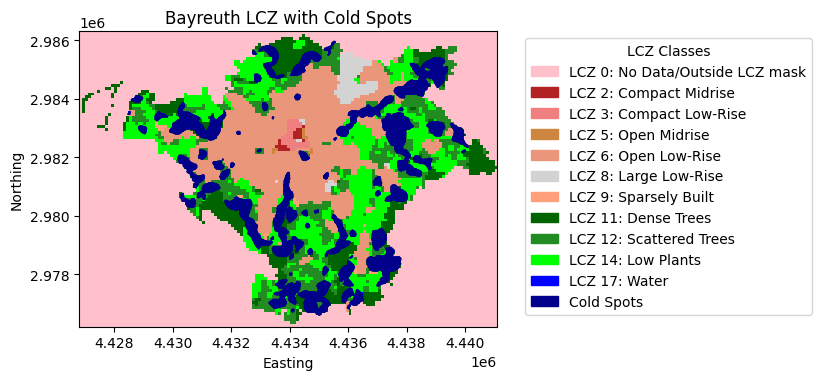

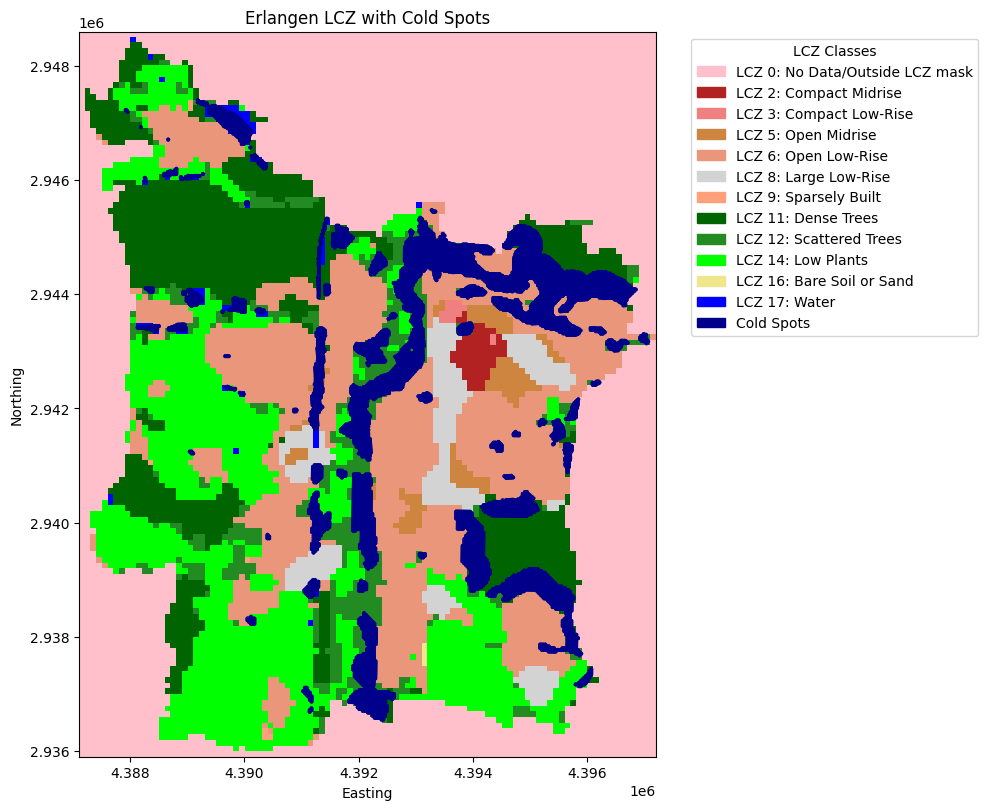

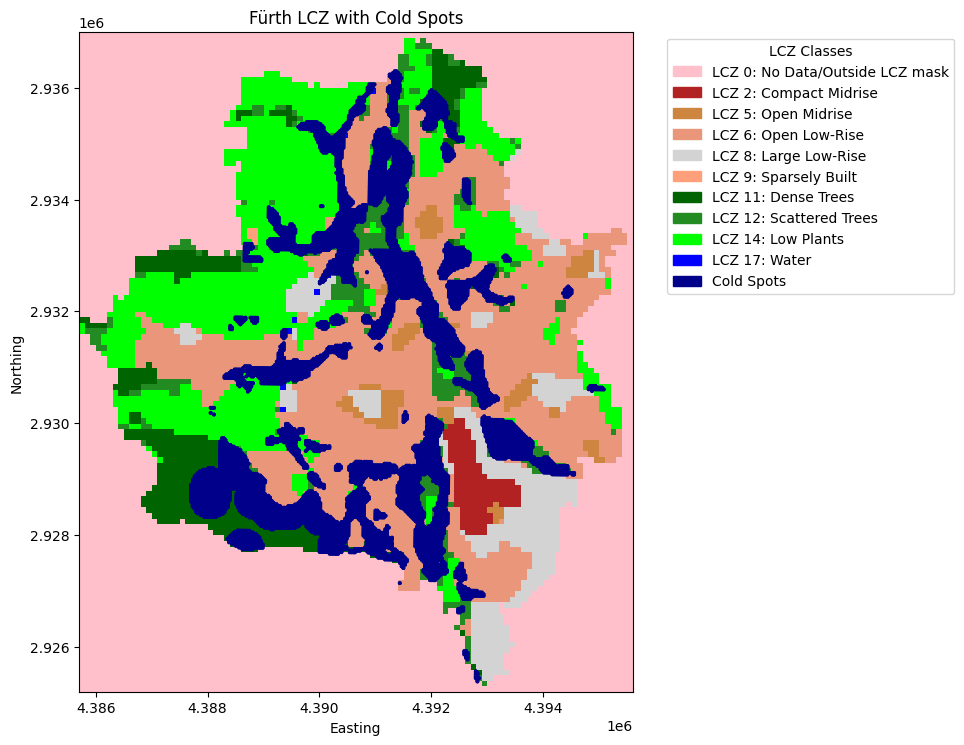

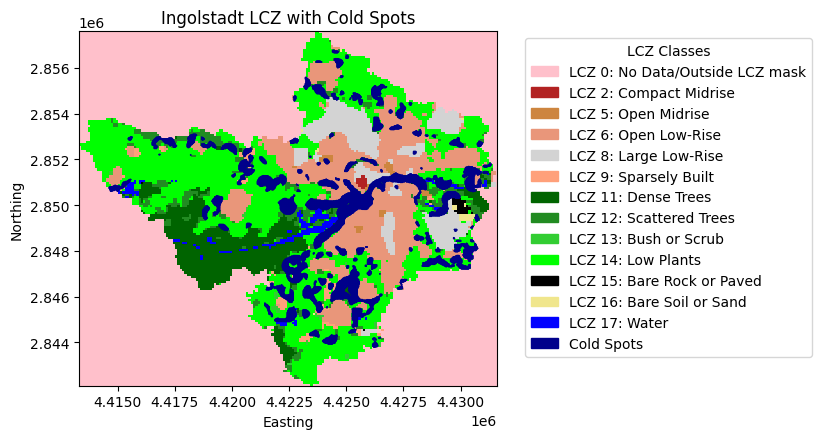

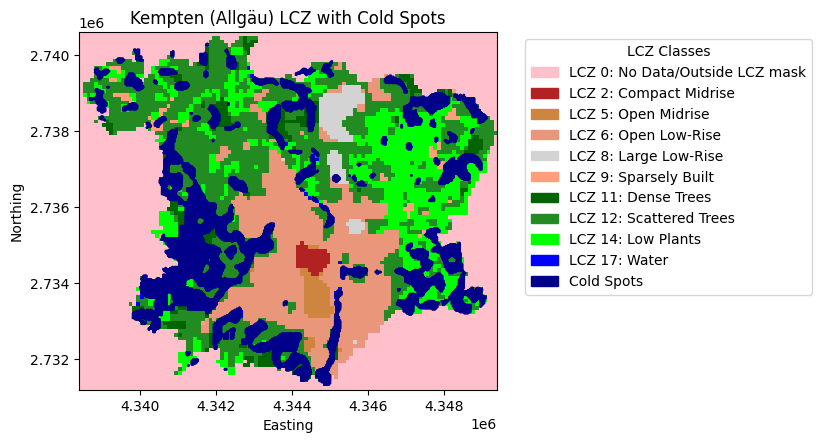

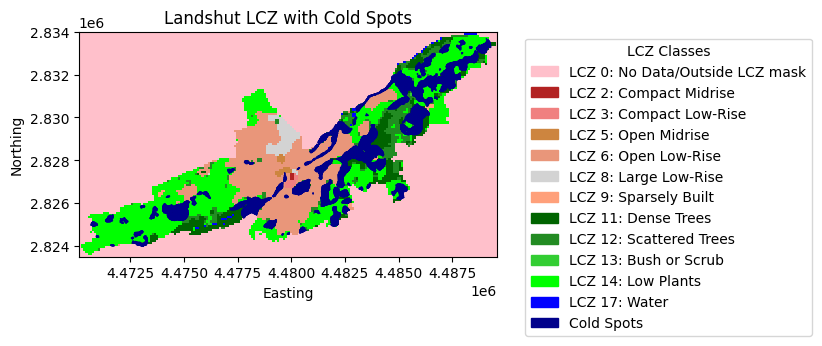

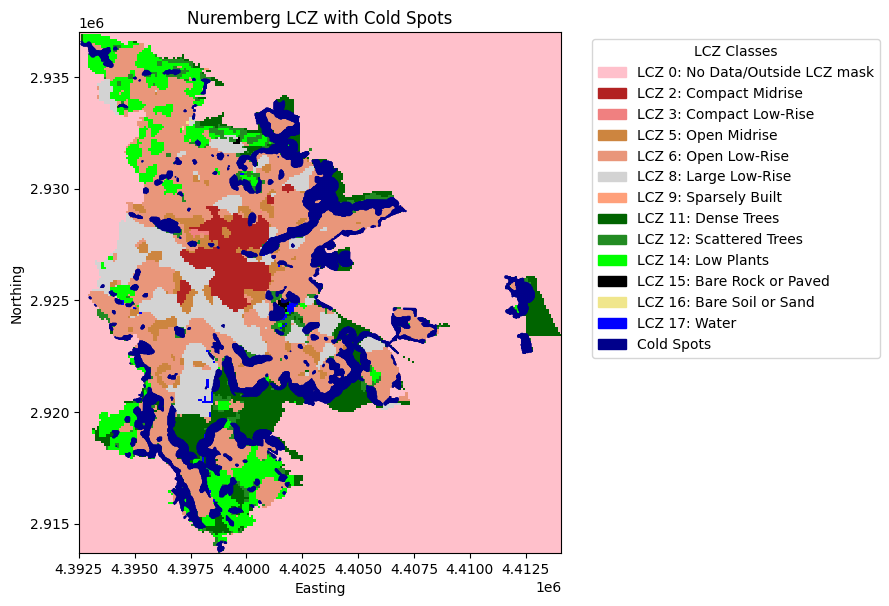

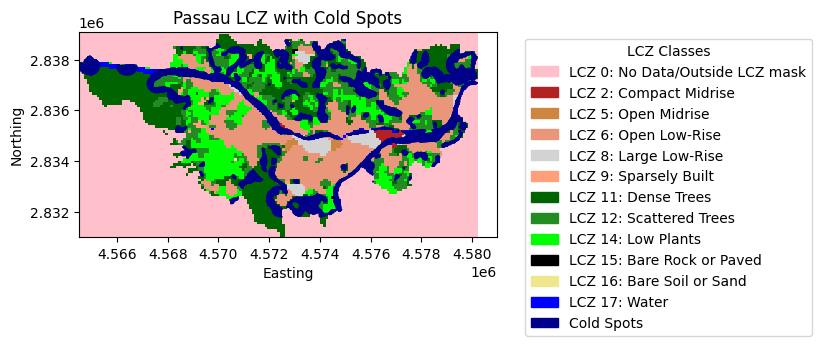

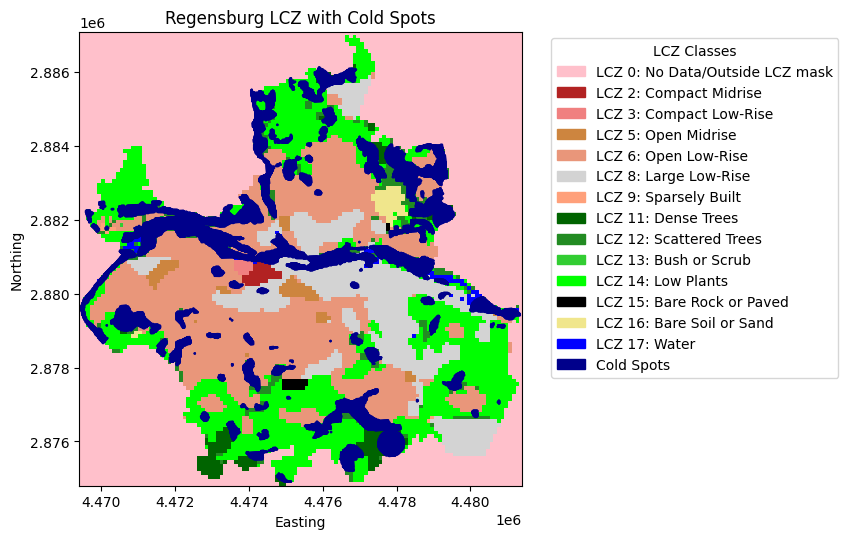

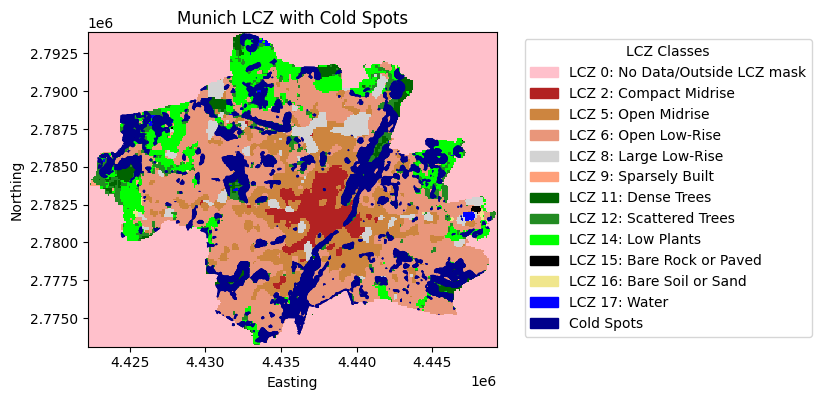

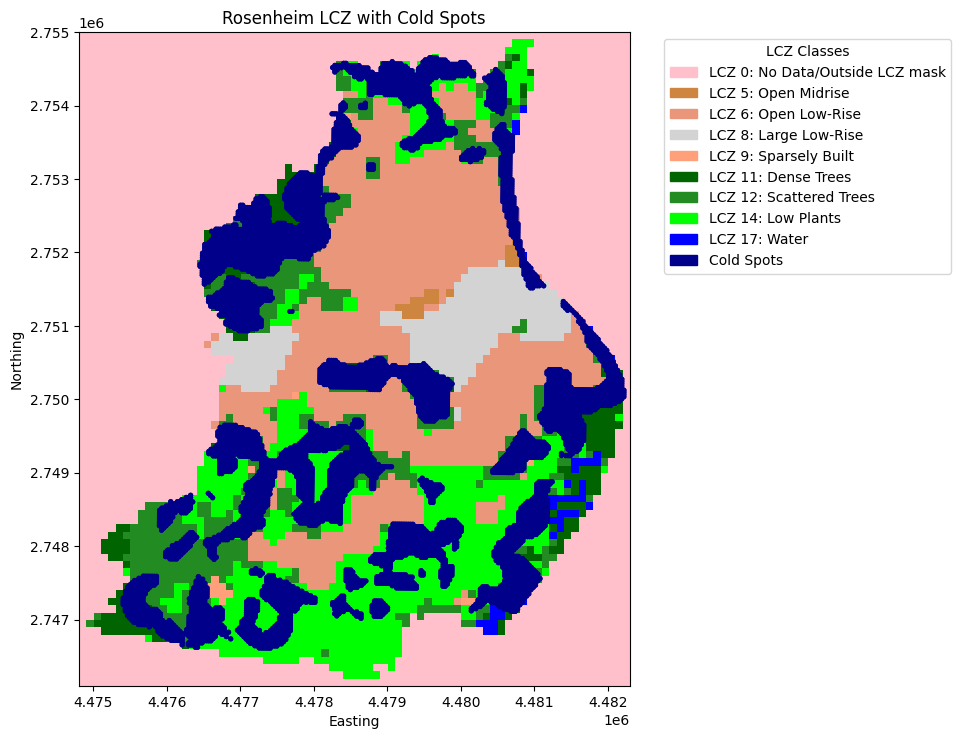

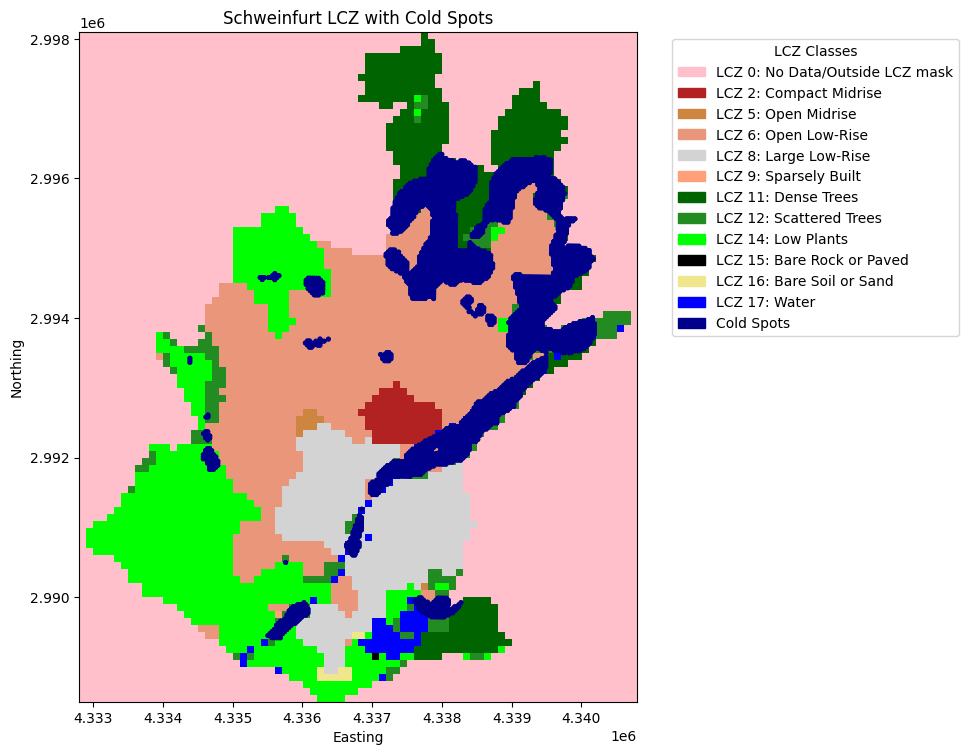

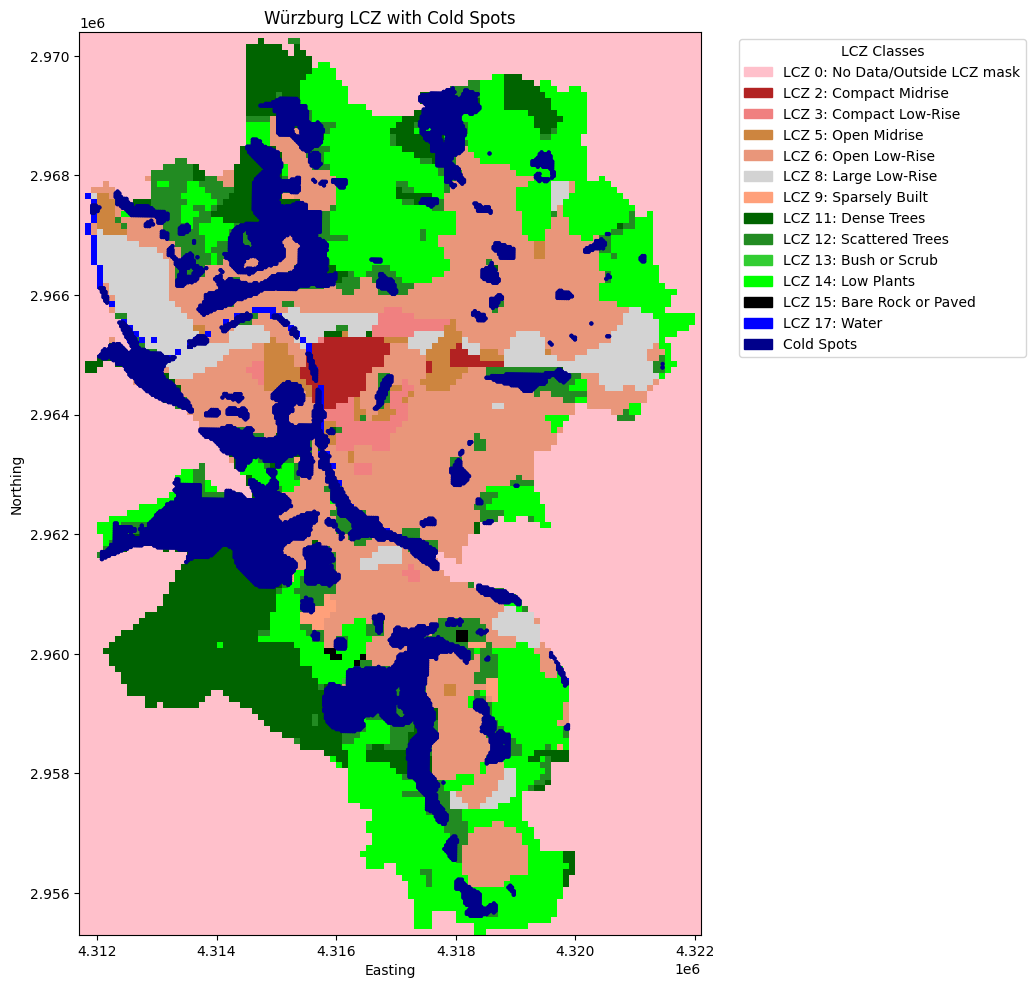

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.patches as mpatches
import numpy as np # Import numpy for np.unique

# Define LCZ descriptions and colors for the legend
# Updated color scheme based on user request
lcz_colors = {
    1: 'darkred',      # Compact High-Rise
    2: 'firebrick',    # Compact Midrise
    3: 'lightcoral',   # Compact Low-Rise
    4: 'sandybrown',   # Open High-Rise (hellbraune)
    5: 'peru',         # Open Midrise (orange) - Adjusted slightly
    6: 'darksalmon',   # Open Low-Rise (lachs)
    7: 'yellow',       # Lightweight Low-Rise
    8: 'lightgray',    # Large Low-Rise
    9: 'lightsalmon',  # Sparsely Built (hell-lachs)
    10: 'dimgray',      # Heavy Industry (dunkelgrau)
    11: 'darkgreen',    # Dense Trees
    12: 'forestgreen',  # Scattered Trees
    13: 'limegreen',    # Bush or Scrub
    14: 'lime',         # Low plants
    15: 'black',        # Bare Rock or Paved
    16: 'khaki',        # Bare Soil or Sand (hellgelb)
    17: 'blue',         # Water
    0: 'pink'          # No Data/Outside LCZ mask (rosa)
}


# Print the results with LCZ descriptions (keeping for reference)
lcz_descriptions = {
    1: "Compact High-Rise", 2: "Compact Midrise", 3: "Compact Low-Rise",
    4: "Open High-Rise", 5: "Open Midrise", 6: "Open Low-Rise",
    7: "Lightweight Low-Rise", 8: "Large Low-Rise", 9: "Sparsely Built",
    10: "Heavy Industry", 11: "Dense Trees", 12: "Scattered Trees",
    13: "Bush or Scrub", 14: "Low Plants", 15: "Bare Rock or Paved",
    16: "Bare Soil or Sand", 17: "Water",
    0: "No Data/Outside LCZ mask" }

# Filter for cities that have both clipped rasters and cold spot data with LCZ values
cities_to_visualize = {
    city: cold_spots_with_lcz[city]
    for city in cold_spots_with_lcz
    if city in clipped_rasters and clipped_rasters[city] is not None
}

if not cities_to_visualize:
    print("No cities with both clipped raster and cold spot data found for visualization.")
else:
    # Iterate through the cities and create a separate plot for each
    for city, cold_spots_gdf in cities_to_visualize.items():
        # Create a new figure for each city
        fig, ax = plt.subplots(1, 1, figsize=(10, 10)) # Adjust figsize as needed for larger plots

        # Get the corresponding clipped raster info
        clipped_raster_info = clipped_rasters[city]
        clipped_data = clipped_raster_info["data"]
        clipped_transform = clipped_raster_info["transform"]

        # Assuming the clipped data is a single band (shape: (1, height, width))
        clipped_band = clipped_data[0]

        # Plot the clipped LCZ raster
        # Use a colormap and specify bounds to map colors to discrete LCZ values
        # We need to create a custom colormap or use a listed colormap for discrete values

        # Get unique LCZ values in the clipped raster band for this city
        unique_lcz_values = np.unique(clipped_band)
        # Filter out the No Data value if present and not relevant for colormap
        # Keep 0 if you want to visualize No Data areas with a specific color
        # unique_lcz_values = unique_lcz_values[unique_lcz_values != 0] # Example if you don't want 0 in colormap

        # Create a colormap and normalization for the unique LCZ values
        # Ensure colors are mapped correctly based on unique values
        colors = [lcz_colors.get(val, 'gray') for val in unique_lcz_values]
        cmap = plt.matplotlib.colors.ListedColormap(colors)

        # Define bounds for the colormap - ensure each unique value falls in its own bin
        # Bounds should cover the range of unique values
        if len(unique_lcz_values) > 0:
            bounds = np.array(unique_lcz_values) - 0.5
            bounds = np.append(bounds, bounds[-1] + 1)
            norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            # Plot the clipped raster with the custom colormap
            image = show(clipped_band, ax=ax, transform=clipped_transform, cmap=cmap, norm=norm, interpolation='nearest')
        else:
            # Handle case with no unique LCZ values (e.g., all NoData)
            print(f"Warning: No unique LCZ values found in clipped raster for {city}. Skipping raster plot.")
            # You might still want to plot the cold spots even without the raster


        # Overlay the cold spot points
        # Filter out cold spots with None LCZ values (outside raster extent) if not already done
        valid_cold_spots = cold_spots_gdf.dropna(subset=['lcz_value'])
        if not valid_cold_spots.empty:
             # Change marker color to darkblue
             valid_cold_spots.plot(ax=ax, marker='o', color='darkblue', markersize=5, label='Cold Spots')


        # Set title
        ax.set_title(f'{city} LCZ with Cold Spots')
        ax.set_xlabel('Easting') # Assuming projected CRS units (meters)
        ax.set_ylabel('Northing') # Assuming projected CRS units (meters)


        # Create a legend for the LCZ colors
        legend_patches = []
        # Sort unique LCZ values for consistent legend order
        sorted_unique_lcz_values = sorted(unique_lcz_values)

        for lcz_val in sorted_unique_lcz_values:
            color = lcz_colors.get(lcz_val, 'grey')
            description = lcz_descriptions.get(lcz_val, 'Unknown LCZ')
            patch = mpatches.Patch(color=color, label=f'LCZ {int(lcz_val)}: {description}')
            legend_patches.append(patch)

        # Add a patch for the Cold Spots layer with the new color
        if not valid_cold_spots.empty:
            cold_spot_patch = mpatches.Patch(color='darkblue', label='Cold Spots')
            legend_patches.append(cold_spot_patch)


        # Add the legend to the plot
        # Position the legend outside the plot if possible
        ax.legend(handles=legend_patches, title="LCZ Classes", bbox_to_anchor=(1.05, 1), loc='upper left')


        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent overlapping and make space for legend
        plt.show()

## Prozentuale Verteilung der Cold Spots pro LCZ (alle Städte)

In [ ]:
import pandas as pd

# Aggregate the LCZ cold spot counts across all cities
# Combine the series from the dictionary into a single Series, summing up counts for each LCZ
all_cities_lcz_counts = pd.concat(lcz_cold_spot_counts.values()).groupby(level=0).sum()

# Calculate the total number of cold spots across all cities
total_cold_spots = all_cities_lcz_counts.sum()

# Calculate the percentage of cold spots for each LCZ
lcz_percentages = (all_cities_lcz_counts / total_cold_spots) * 100

# Sort the percentages in descending order for better readability
lcz_percentages_sorted = lcz_percentages.sort_values(ascending=False)

print("Prozentuale Verteilung der Cold Spots pro LCZ (alle Städte zusammen) 2019-2024:")

# Print the results with LCZ descriptions
lcz_descriptions = {
    1: "Compact High-Rise", 2: "Compact Midrise", 3: "Compact Low-Rise",
    4: "Open High-Rise", 5: "Open Midrise", 6: "Open Low-Rise",
    7: "Lightweight Low-Rise", 8: "Large Low-Rise", 9: "Sparsely Built",
    10: "Heavy Industry", 11: "Dense Trees", 12: "Scattered Trees",
    13: "Bush or Scrub", 14: "Low Plants", 15: "Bare Rock or Paved",
    16: "Bare Soil or Sand", 17: "Water",
    0: "No Data/Outside LCZ mask"
}

for lcz_value, percentage in lcz_percentages_sorted.items():
    # Ensure LCZ value is an integer for lookup
    lcz_value_int = int(lcz_value)
    description = lcz_descriptions.get(lcz_value_int, "Unknown LCZ")
    print(f"LCZ {lcz_value_int} ({description}): {percentage:.2f}%")

Prozentuale Verteilung der Cold Spots pro LCZ (alle Städte zusammen) 2019-2024:
LCZ 12 (Scattered Trees): 32.43%
LCZ 11 (Dense Trees): 29.94%
LCZ 6 (Open Low-Rise): 15.00%
LCZ 14 (Low Plants): 14.66%
LCZ 17 (Water): 4.37%
LCZ 0 (No Data/Outside LCZ mask): 1.03%
LCZ 5 (Open Midrise): 0.99%
LCZ 9 (Sparsely Built): 0.77%
LCZ 8 (Large Low-Rise): 0.63%
LCZ 2 (Compact Midrise): 0.09%
LCZ 15 (Bare Rock or Paved): 0.05%
LCZ 13 (Bush or Scrub): 0.03%
LCZ 16 (Bare Soil or Sand): 0.01%
LCZ 3 (Compact Low-Rise): 0.00%


# Plots

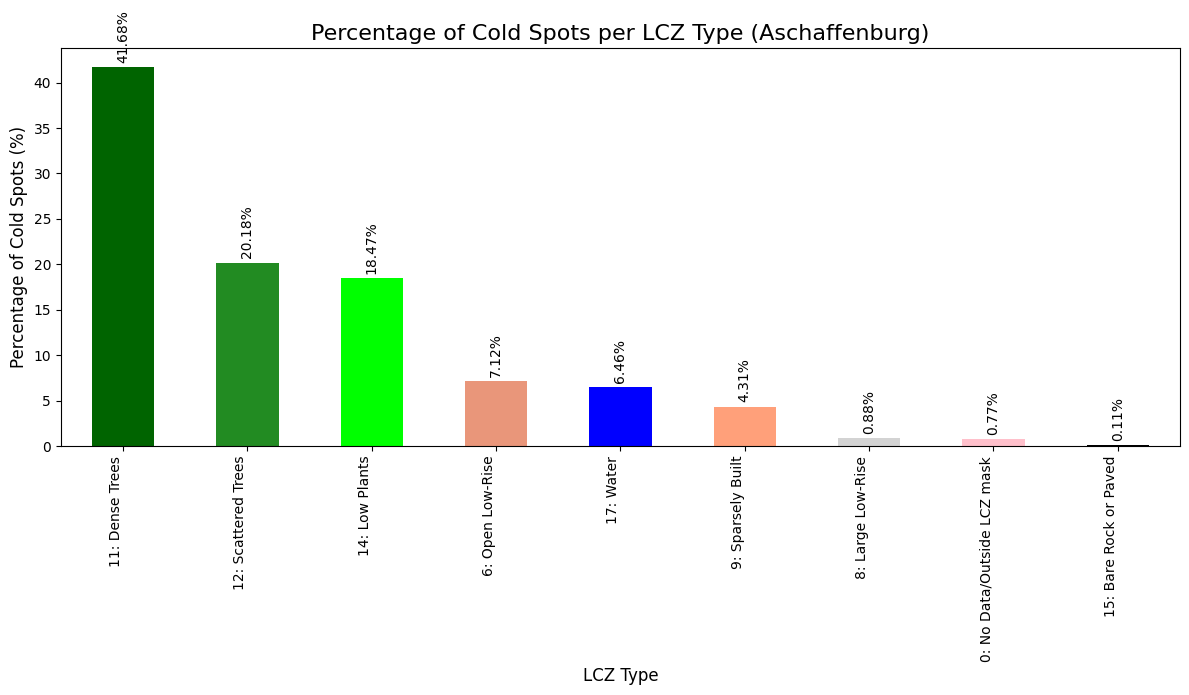

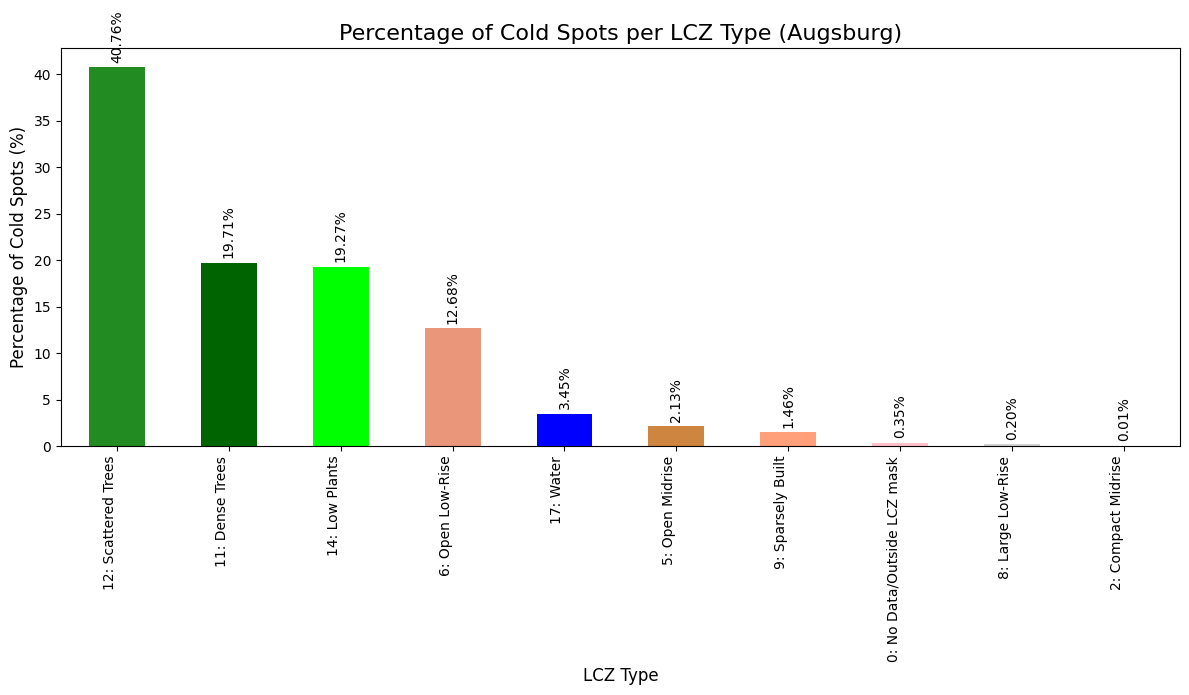

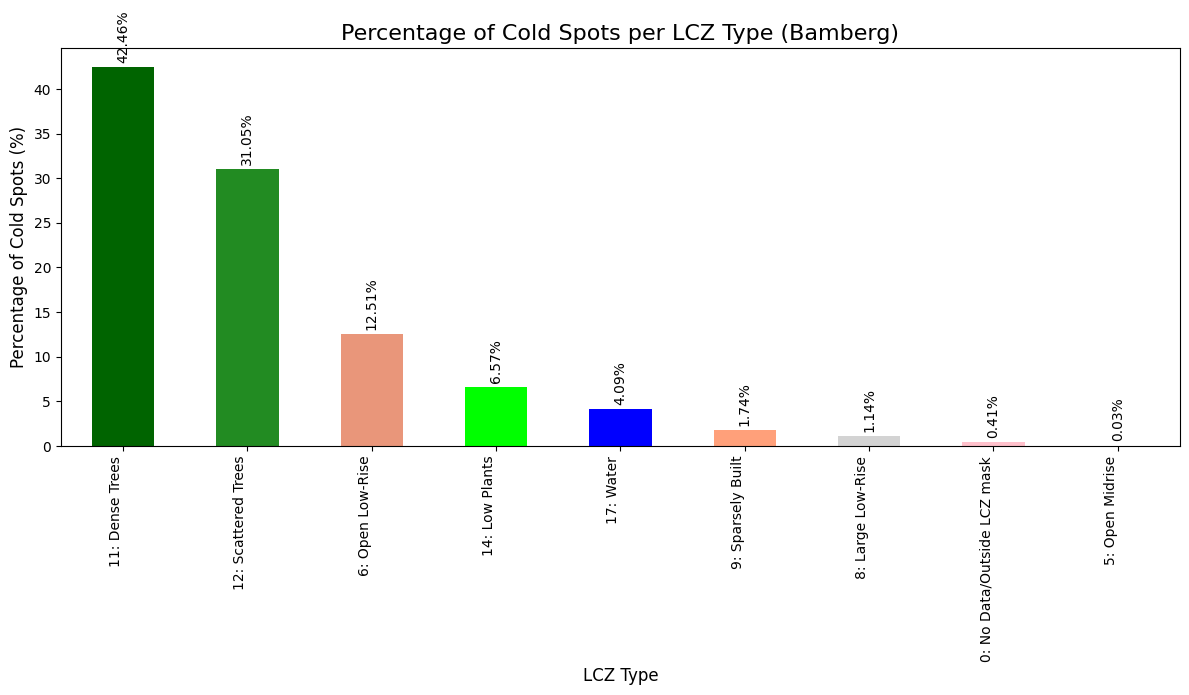

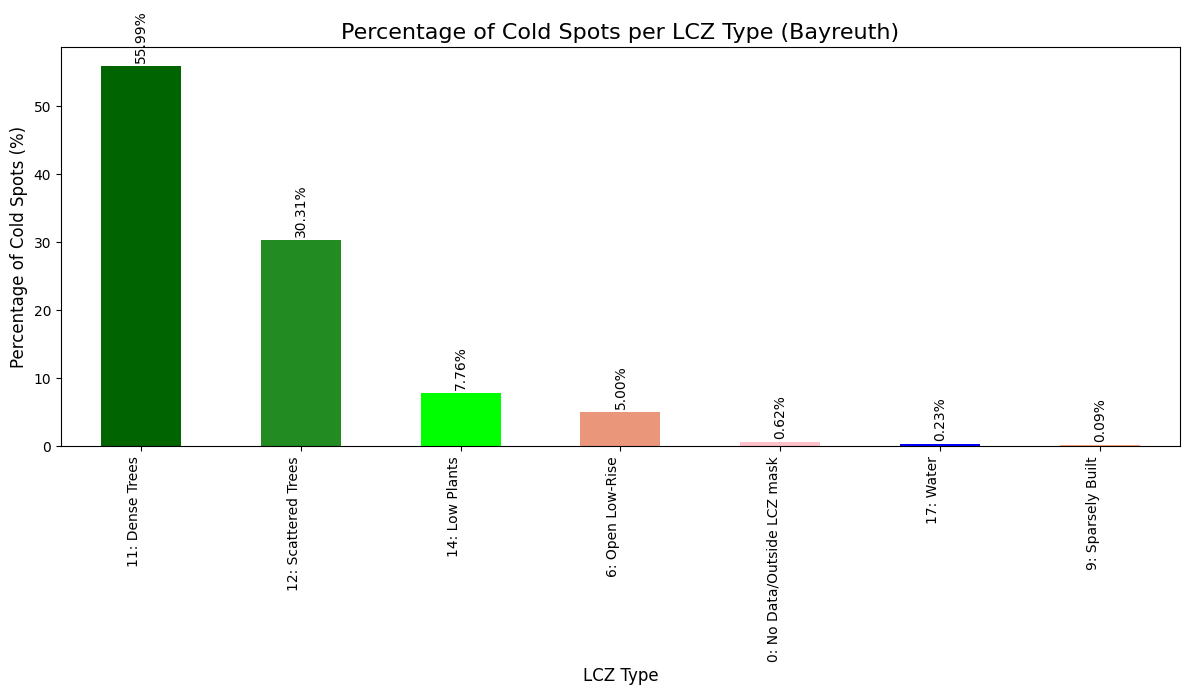

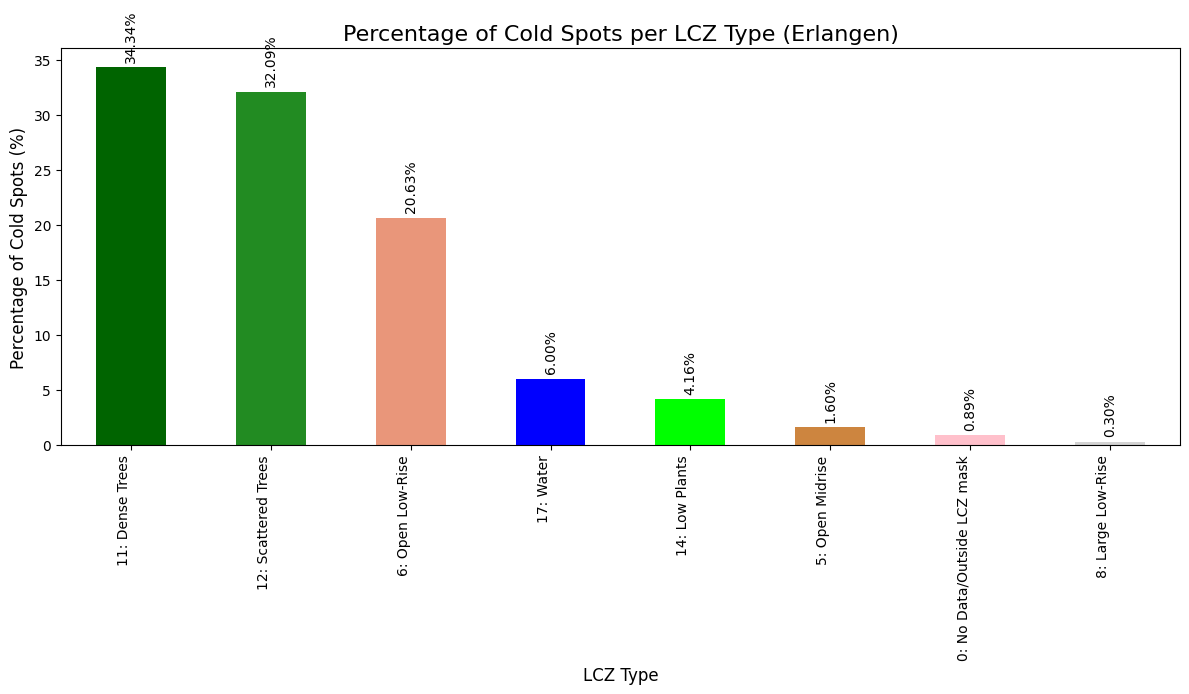

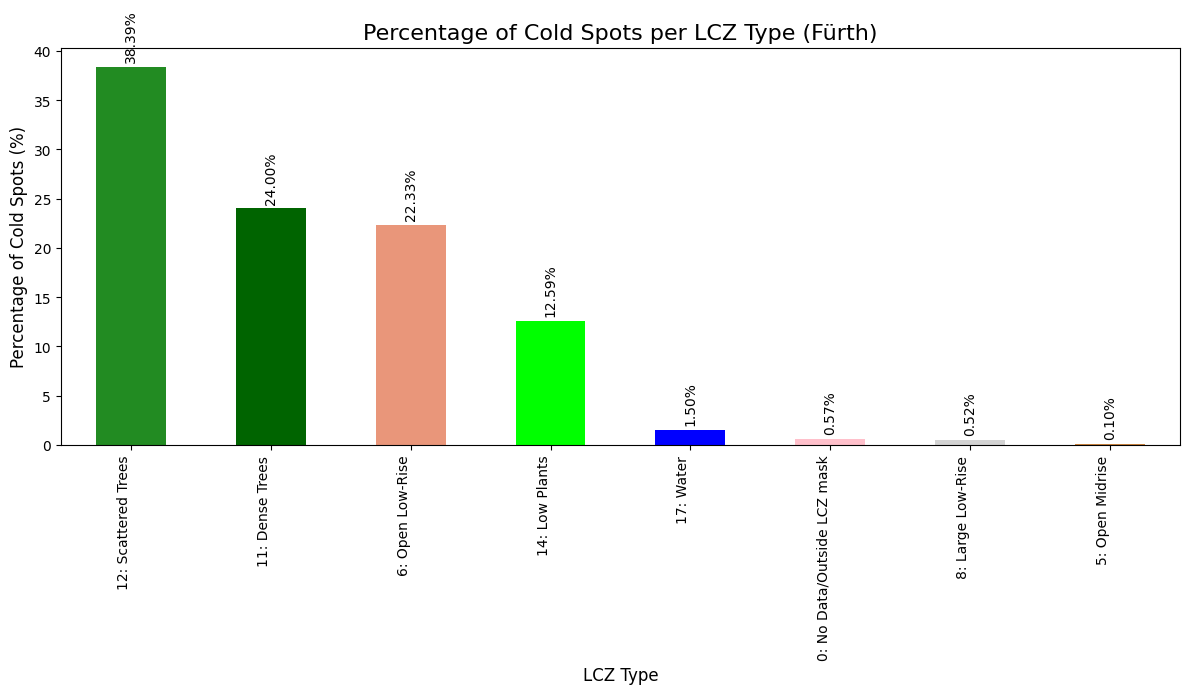

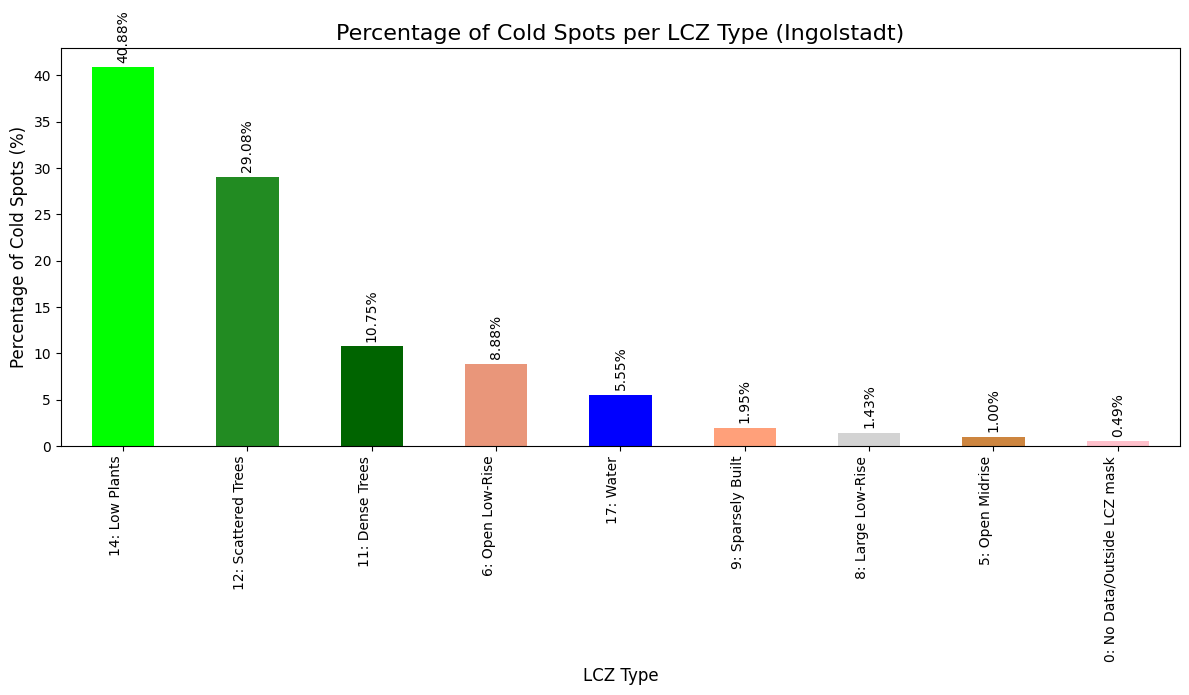

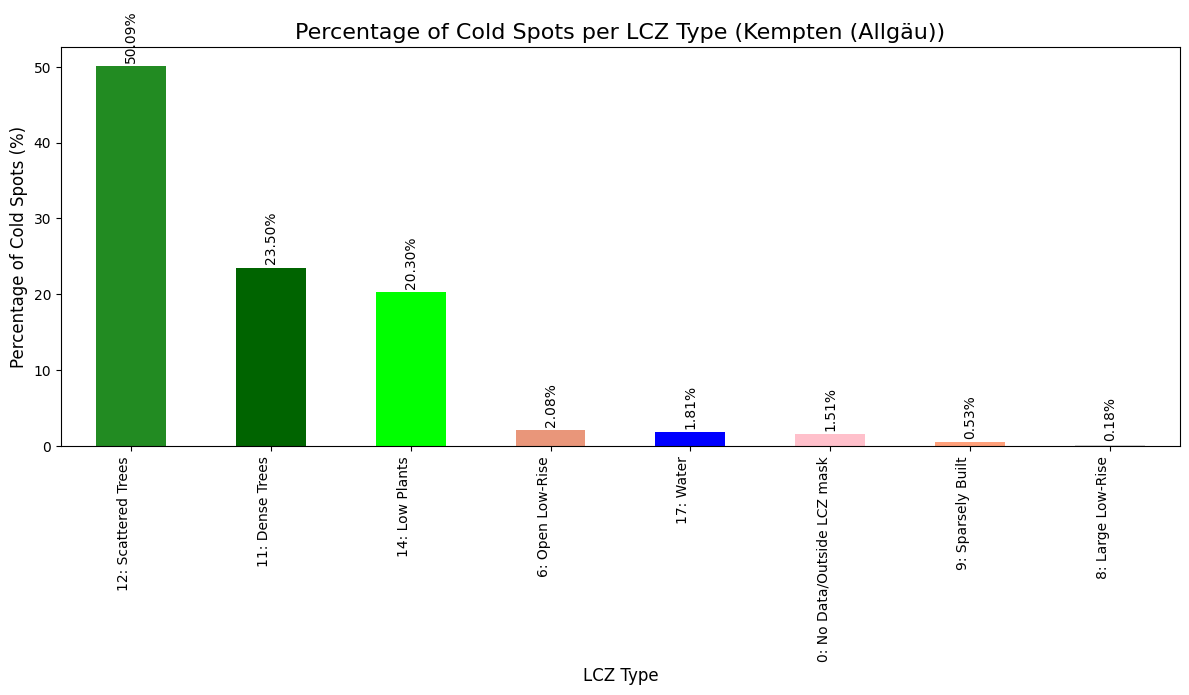

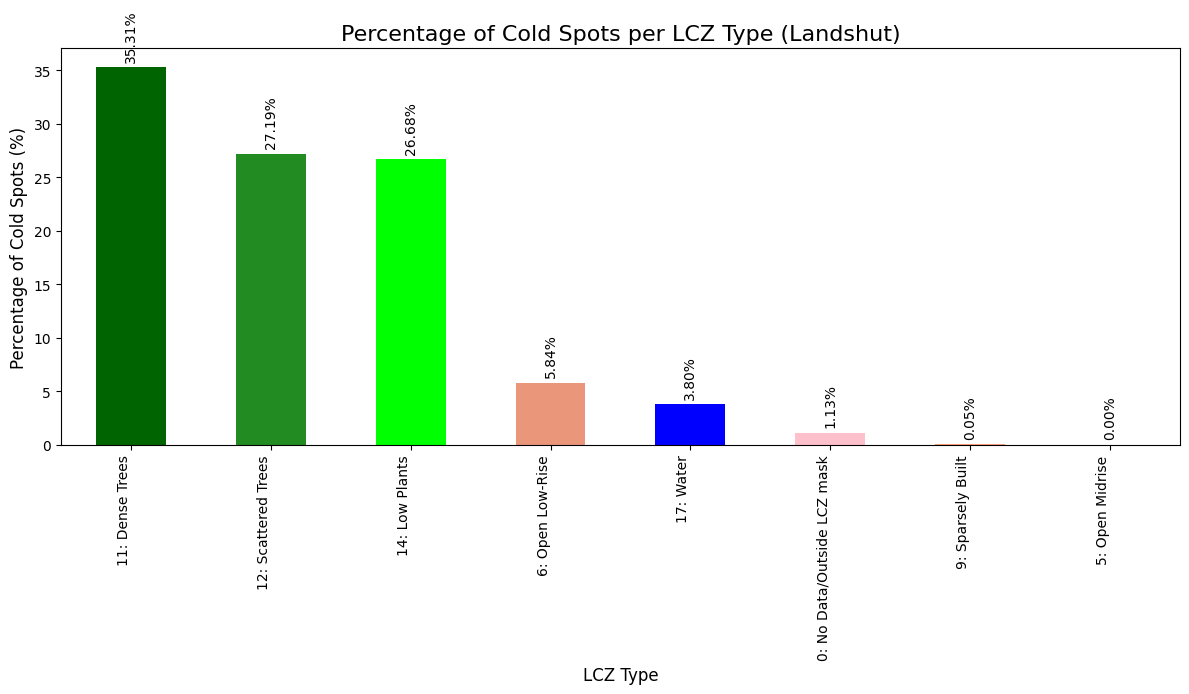

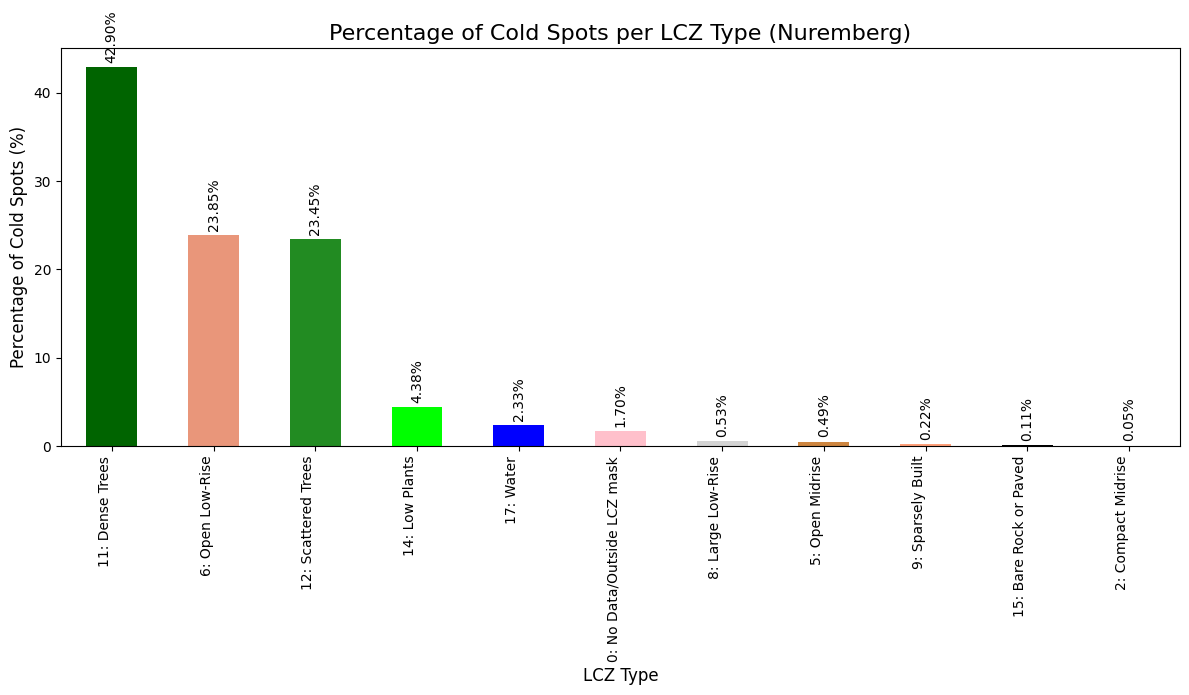

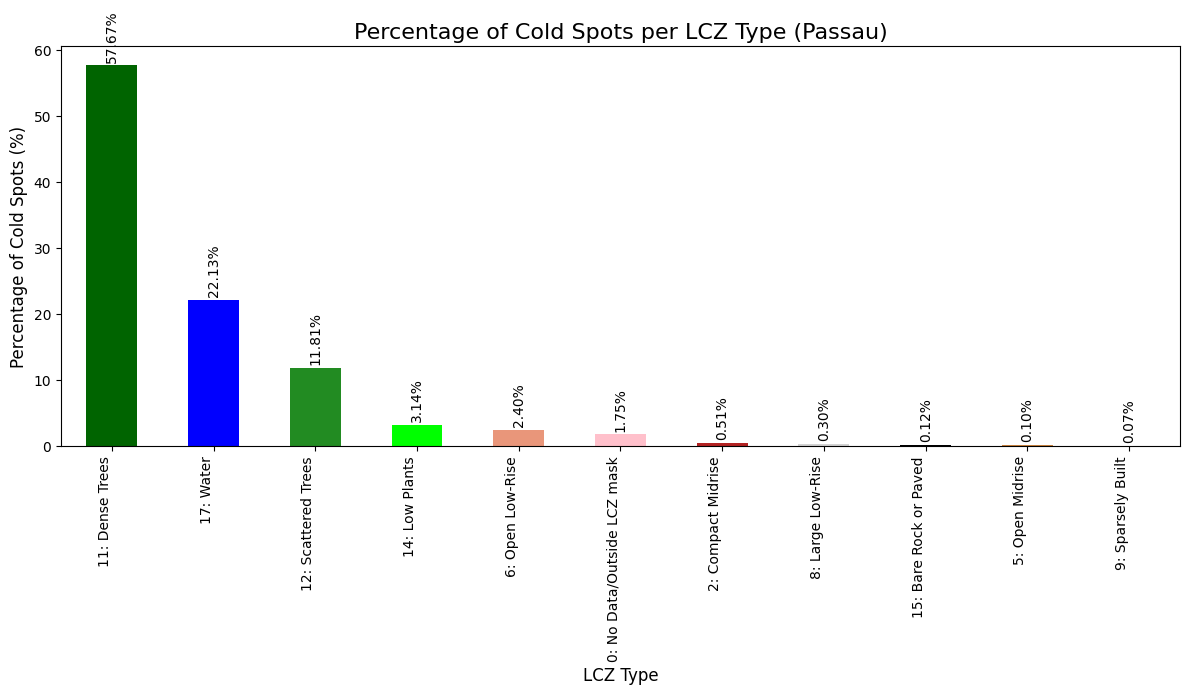

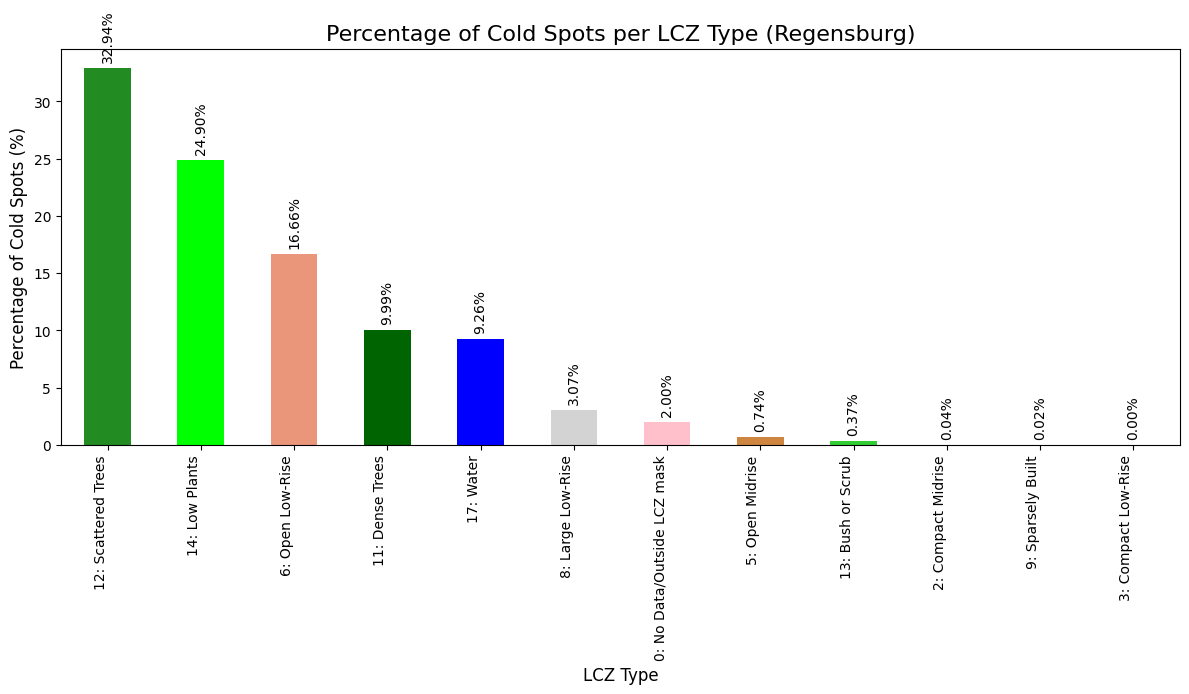

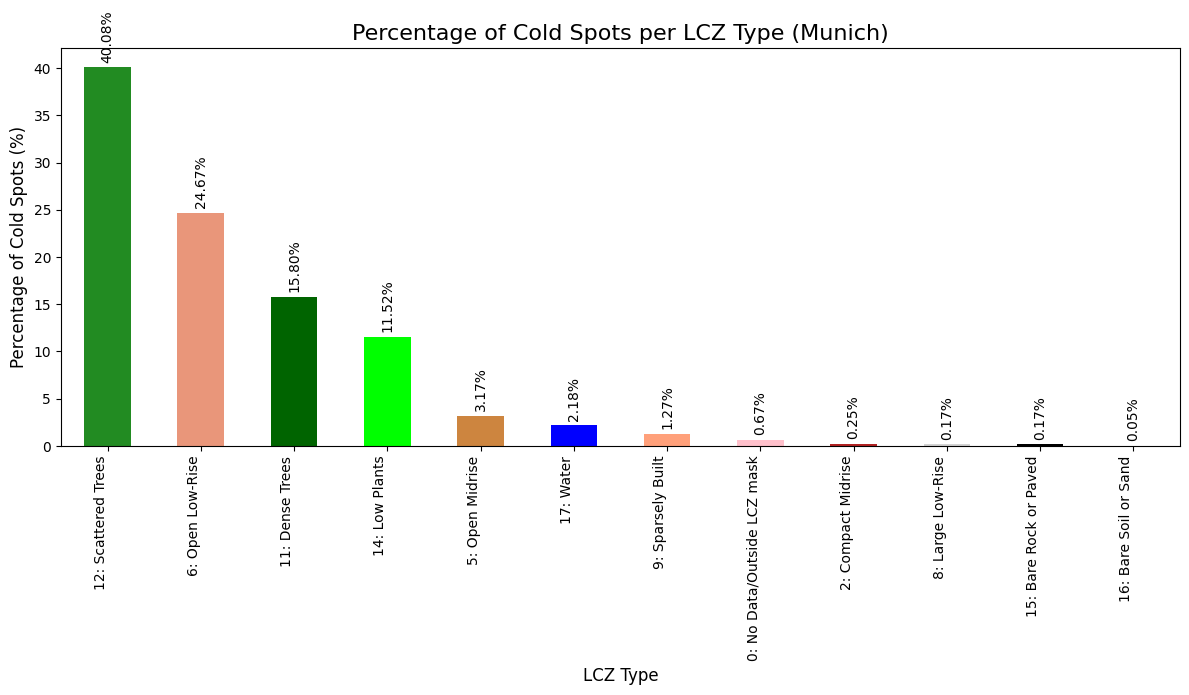

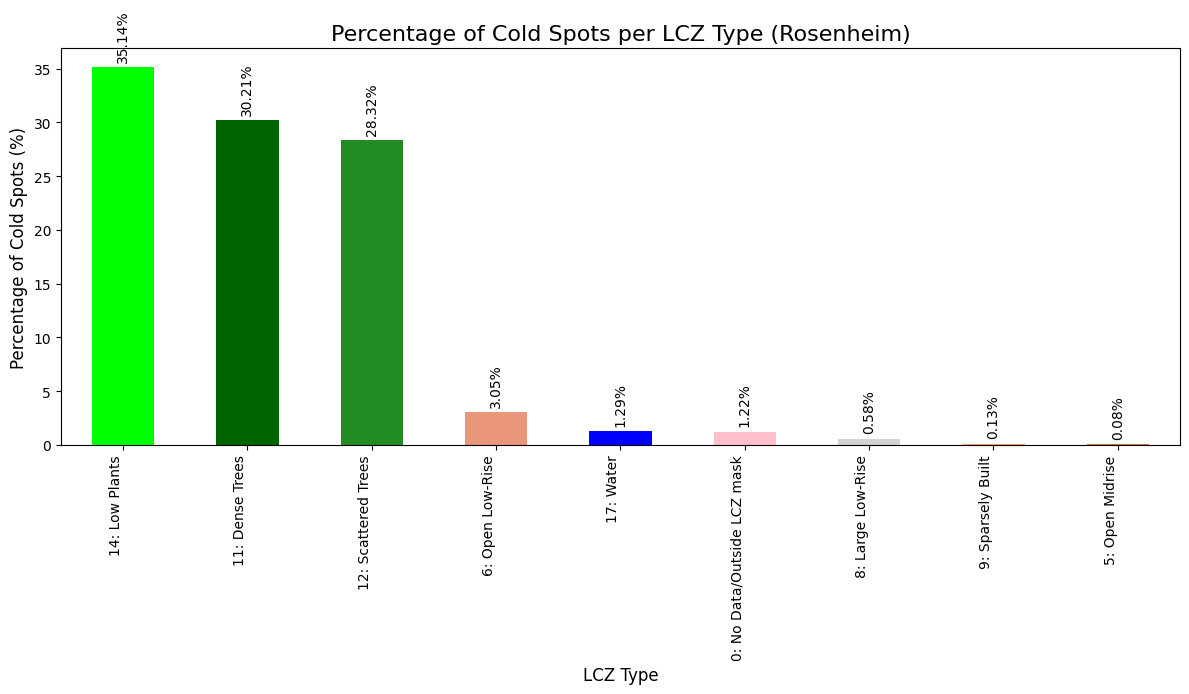

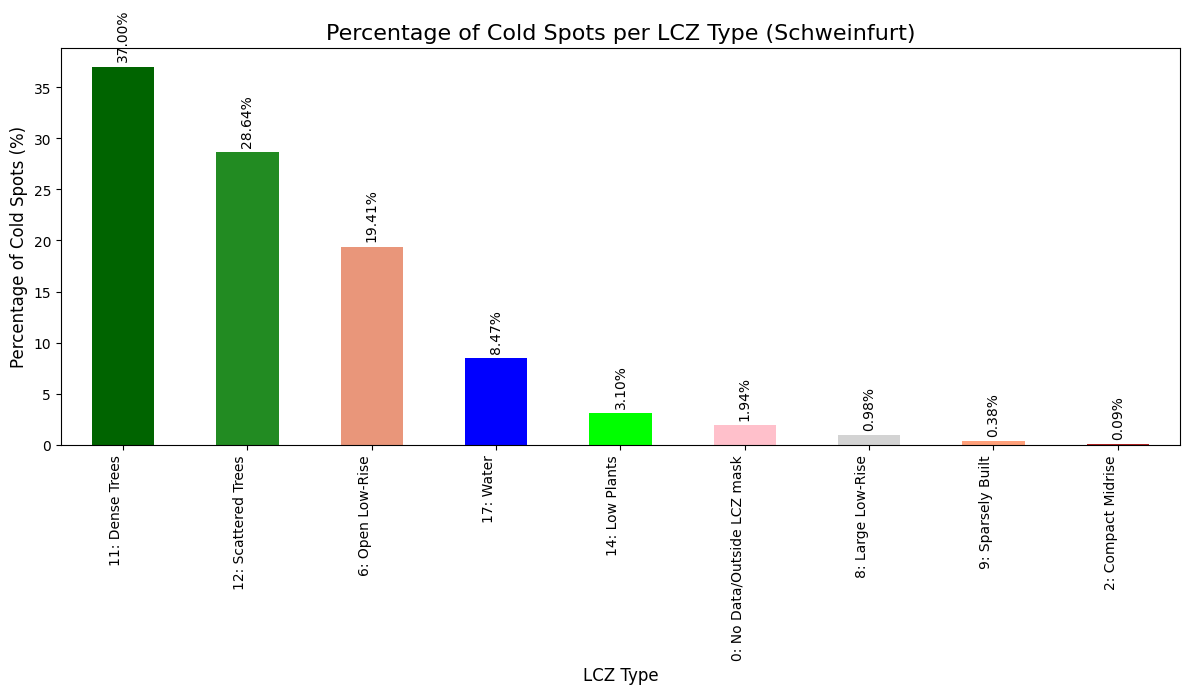

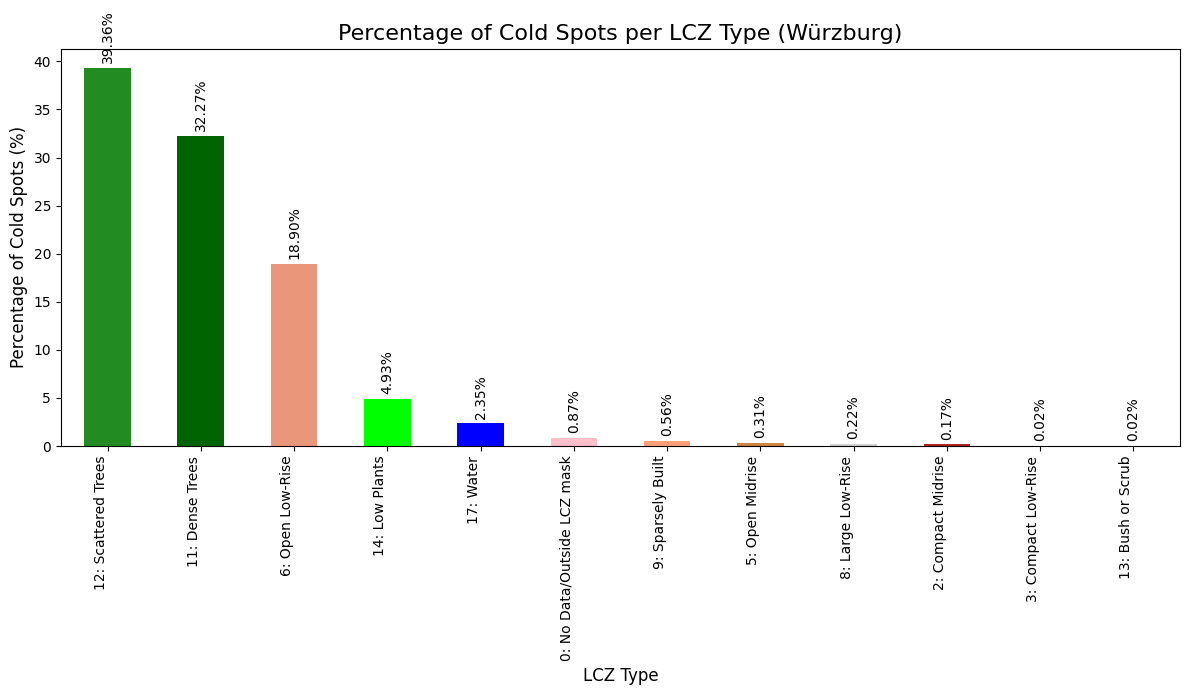

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure lcz_cold_spot_counts and lcz_descriptions and lcz_colors are available
if 'lcz_cold_spot_counts' in locals() and 'lcz_descriptions' in locals() and 'lcz_colors' in locals():

    # Iterate through each city's cold spot counts
    for city, lcz_counts in lcz_cold_spot_counts.items():
        # Calculate the total number of cold spots for the current city
        total_cold_spots_city = lcz_counts.sum()

        if total_cold_spots_city > 0:
            # Calculate the percentage of cold spots for each LCZ in the current city
            lcz_percentages_city = (lcz_counts / total_cold_spots_city) * 100

            # Sort the percentages in descending order
            lcz_percentages_city_sorted = lcz_percentages_city.sort_values(ascending=False)

            # Map LCZ numbers to descriptions for plotting
            lcz_labels_city = [f"{int(lcz_value)}: {lcz_descriptions.get(int(lcz_value), 'Unknown LCZ')}" for lcz_value in lcz_percentages_city_sorted.index]

            # Get colors for each LCZ in the sorted order
            bar_colors = [lcz_colors.get(int(lcz_value), 'gray') for lcz_value in lcz_percentages_city_sorted.index]

            # Create a bar plot for the current city
            plt.figure(figsize=(12, 7)) # Adjust figure size as needed
            # Use the determined colors for the bars
            lcz_percentages_city_sorted.plot(kind='bar', color=bar_colors)


            # Set x-axis labels to LCZ descriptions
            plt.xticks(range(len(lcz_labels_city)), lcz_labels_city, rotation=90, ha='right')

            # Set plot title and axis labels
            plt.title(f'Percentage of Cold Spots per LCZ Type ({city})', fontsize=16)
            plt.xlabel('LCZ Type', fontsize=12)
            plt.ylabel('Percentage of Cold Spots (%)', fontsize=12)

            # Add percentage values on top of the bars (optional)
            for i, percentage in enumerate(lcz_percentages_city_sorted.values):
                plt.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center', va='bottom', rotation=90)

            plt.tight_layout()
            plt.show()
        else:
            print(f"No cold spots with valid LCZ values found for {city} to plot percentages.")

else:
    print("Required data (lcz_cold_spot_counts, lcz_descriptions, or lcz_colors) not found. Please run previous cells.")

 ## stacked Barplots

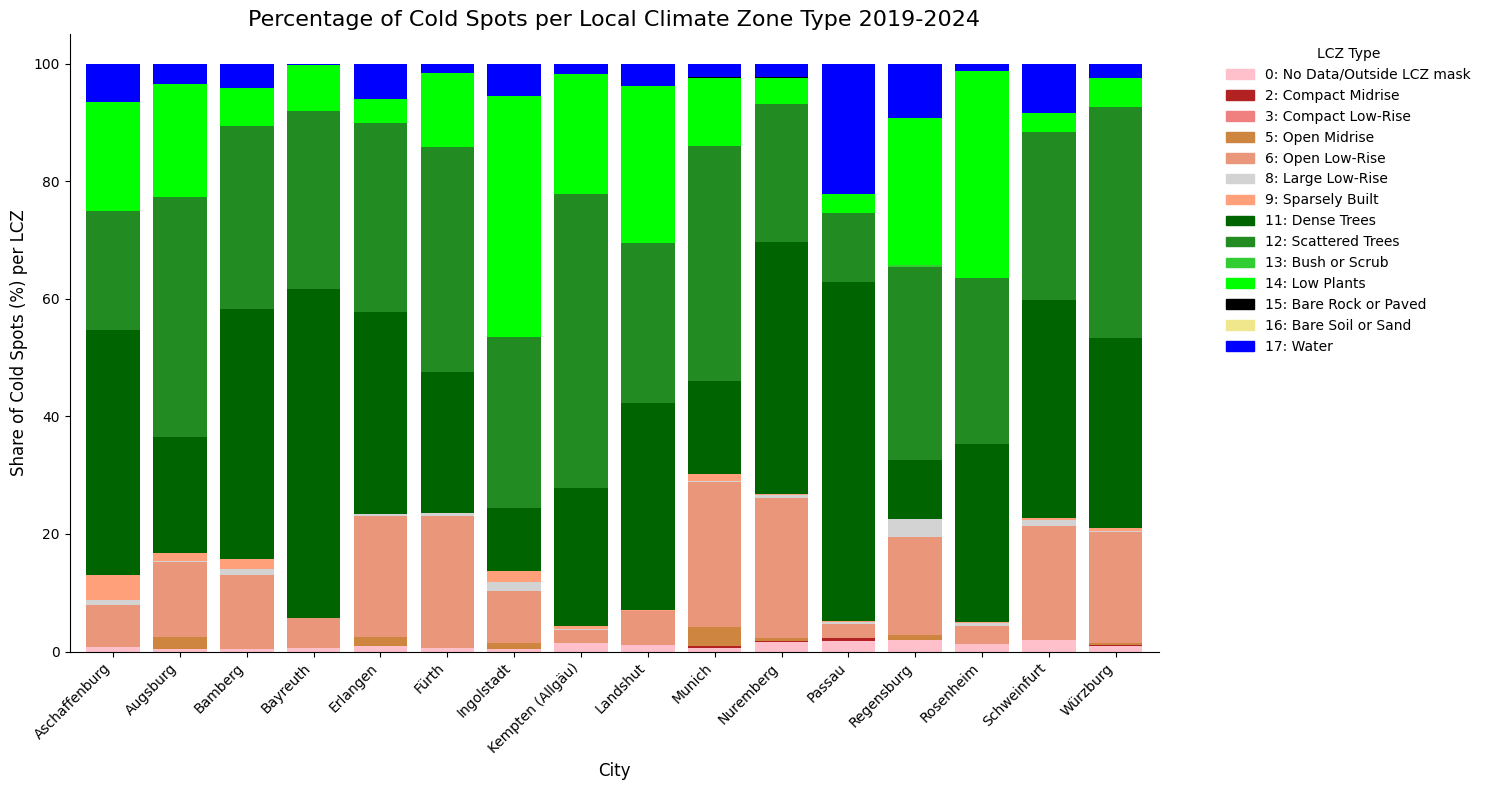

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches # Import mpatches for legend customization

# Ensure lcz_cold_spot_counts and lcz_descriptions are available
if 'lcz_cold_spot_counts' in locals() and 'lcz_descriptions' in locals() and 'lcz_colors' in locals():

    # Prepare data for grouped bar chart
    # We need a DataFrame where index is LCZ type, columns are cities, and values are percentages
    lcz_percentages_per_city = {}
    all_lcz_types = set()

    for city, lcz_counts in lcz_cold_spot_counts.items():
        total_cold_spots_city = lcz_counts.sum()
        if total_cold_spots_city > 0:
            lcz_percentages_city = (lcz_counts / total_cold_spots_city) * 100
            lcz_percentages_per_city[city] = lcz_percentages_city
            all_lcz_types.update(lcz_percentages_city.index)

    # Create a DataFrame from the percentages
    # Use all unique LCZ types as the index to ensure all cities have entries for all LCZs (fill missing with 0)
    all_lcz_types_sorted = sorted(list(all_lcz_types))
    lcz_percentage_df = pd.DataFrame(lcz_percentages_per_city).reindex(all_lcz_types_sorted, fill_value=0)

    # Map LCZ numbers to descriptions for better labels
    lcz_labels = [f"{int(lcz_value)}: {lcz_descriptions.get(int(lcz_value), 'Unknown LCZ')}" for lcz_value in lcz_percentage_df.index]
    lcz_percentage_df.index = lcz_labels

    # Sort cities alphabetically for plotting
    lcz_percentage_df_sorted_cities = lcz_percentage_df.sort_index(axis=1)


    # Select colors for the stacked bars based on the LCZ types in the DataFrame index
    # Ensure the colors are in the same order as the DataFrame index (lcz_labels)
    bar_colors = [lcz_colors.get(int(lcz_value.split(':')[0]), 'gray') for lcz_value in lcz_percentage_df_sorted_cities.index] # Use sorted df index


    # Plotting the stacked bar chart
    ax = lcz_percentage_df_sorted_cities.T.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8, color=bar_colors) # Use sorted df


    # Set plot title and axis labels
    plt.title('Percentage of Cold Spots per Local Climate Zone Type 2019-2024', fontsize=16)
    plt.xlabel('City', fontsize=12)
    plt.ylabel('Share of Cold Spots (%) per LCZ', fontsize=12)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    # Improve legend (optional, can be complex with many LCZs)
    # Create legend patches with correct colors and labels
    legend_patches = []
    # The order of patches should match the order of columns in the transposed DataFrame (which is the index of the original df)
    for lcz_label in lcz_percentage_df_sorted_cities.index: # Use sorted df index
        lcz_value = int(lcz_label.split(':')[0])
        color = lcz_colors.get(lcz_value, 'gray')
        patch = mpatches.Patch(color=color, label=lcz_label)
        legend_patches.append(patch)

    # Add the legend to the plot and remove the frame
    legend = ax.legend(handles=legend_patches, title="LCZ Type", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False) # Add frameon=False

    # Attempt to left-align the legend title
    legend.get_title().set_ha('left')


    plt.xticks(rotation=45, ha='right') # Rotate city labels
    plt.tight_layout()
    plt.show()

else:
    print("Required data (lcz_cold_spot_counts or lcz_descriptions or lcz_colors) not found. Please run previous cells.")